# Lego World Map

Code inspired from Milan Janosov to create a stylized elevation map of the world.

You can read about his work creating a Lego elevation map of Budapest [here](https://open.substack.com/pub/milanjanosov/p/lego-elevation-map?r=3mp6w8&utm_medium=ios) on his Substack.

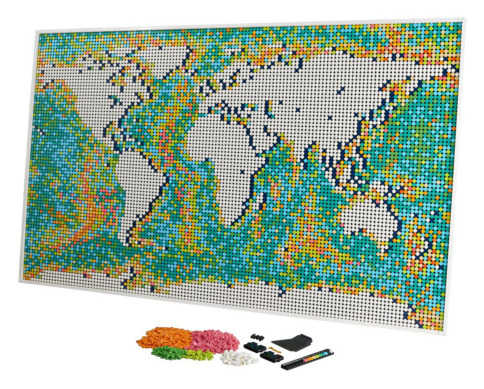

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# https://jaysbrickblog.com/wp-content/uploads/2021/05/\
# LEGO-31203-World-Map-Product-Photo-1024x815.jpg
img = mpimg.imread('figures/LEGO-31203-World-Map-Product-Photo-1024x815.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Lego has previously made a world map, but I think I could do a little better!

## Imports

In [87]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.features import rasterize, geometry_mask
from rasterio.transform import from_bounds
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
import sys
import subprocess
import glob
import string
from osgeo import gdal
from pathlib import Path
import os
from shapely.geometry import box, LineString
from shapely.affinity import scale
from PIL import Image, ImageEnhance
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import KMeans
from rasterstats import zonal_stats
import math
from scipy import ndimage

DEM Raster data sourced from here:

https://earthexplorer.usgs.gov

## Helper Functions

In [3]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [4]:
seed=rand_gen()
seed

122

In [5]:
# save random seed for project
with open('seed.txt', 'w') as file:
    file.write(str(seed))

In [6]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x178133CA0

## Merge DEMs

In [7]:
# adapted from https://gis.stackexchange.com/questions/449569/\
# merging-a-large-number-of-geotiff-files-via-gdal-merge-py

# paths
input_folder=Path('../_data/world_data/dem_tile_world_gtopo30')
output_folder=Path('../_data/world_data')
output_file=output_folder / "dem_world_gtopo30.tiff"
vrt_file=output_folder / "merged.vrt"

# create output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# find and list all .tif files
input_files = [Path(file) for file in glob.glob(str(input_folder / '*.tif'))]
print(f"Found {len(input_files)} files to merge.")

# dictionary for temporary short names
# to manage potentially long filenames
original_names = {}
characters = string.digits + string.ascii_letters

# temporarily rename files to short names
print("Renaming files temporarily...")
for i, file in enumerate(input_files):
    new_name = f"{characters[i % len(characters)]}{characters[i // len(characters)]}.t"
    new_path = file.parent / new_name
    file.rename(new_path)
    original_names[new_path] = file

# build VRT from renamed files
print("Building VRT file...")
gdal.BuildVRT(str(vrt_file), [str(file) for file in original_names.keys()])

# translate VRT to TIFF
print("Translating VRT to TIFF...")
gdal.Translate(str(output_file), str(vrt_file))

# restore original file names
print("Restoring original file names...")
for new_path, original_path in original_names.items():
    new_path.rename(original_path)

# clean up VRT file
print("Cleaning up temporary files...")
vrt_file.unlink()

print(f"Merging completed. Final output located at: {output_file}")

Found 33 files to merge.
Renaming files temporarily...
Building VRT file...
Translating VRT to TIFF...
Restoring original file names...
Cleaning up temporary files...
Merging completed. Final output located at: ../_data/world_data/dem_world_gtopo30.tiff


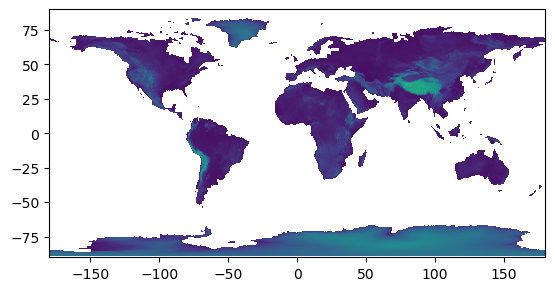

<Axes: >

In [8]:
# view file
fp=r'../_data/world_data/dem_world_gtopo30.tiff'
img=rio.open(fp)
show(img)

Saved image to ../_figs/dem_world.jpg


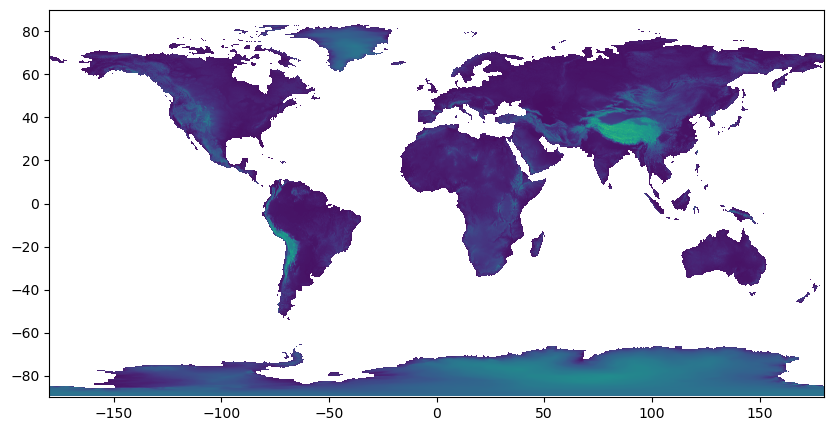

In [9]:
# save as jpg for posterity

# define paths
tiff_file=Path('../_data/world_data/dem_world_gtopo30.tiff')
output_image=Path('../_figs/dem_world.jpg')
output_image.parent.mkdir(parents=True,exist_ok=True)

# open and save as jpg
with rio.open(tiff_file) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src,ax=ax)
    plt.savefig(output_image,format="jpg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    
print(f'Saved image to {output_image}')

In [54]:
# confirm cell size and dimensions of raster
# Path to the GeoTIFF file
file_path = '../_data/world_data/dem_world_gtopo30.tiff'

# Open the GeoTIFF file
with rio.open(file_path) as src:
    # Get pixel size (resolution)
    transform = src.transform
    pixel_width = abs(transform.a)  # Pixel width (x-direction)
    pixel_height = abs(transform.e)  # Pixel height (y-direction)
    
    # Get raster dimensions
    width = src.width  # Number of pixels in x-direction
    height = src.height  # Number of pixels in y-direction
    
    # Calculate aspect ratio
    aspect_ratio = width / height

# Print the results
print(f"Pixel size: {pixel_width} x {pixel_height}")
print(f"Raster dimensions: {width} x {height}")
print(f"Aspect ratio: {aspect_ratio:.2f} ({'landscape' if aspect_ratio > 1 else 'portrait' if aspect_ratio < 1 else 'square'})")

Pixel size: 0.00833333333333 x 0.00833333333333
Raster dimensions: 43200 x 21600
Aspect ratio: 2.00 (landscape)


## "Lego-fy" or downsample polygon of earth

Now we have to rasterize the elevation map. This is crucial as we'll be eventually making this map in Lego, which are bricks (duh).

We need to have a look at the boundaries of the world. I have a file downloaded already:

In [10]:
import geopandas as gpd
import shapely
print(f'GeoPandas version: {gpd.__version__}')
print(f'Shapely version: {shapely.__version__}')

GeoPandas version: 0.14.2
Shapely version: 2.0.6


<Axes: >

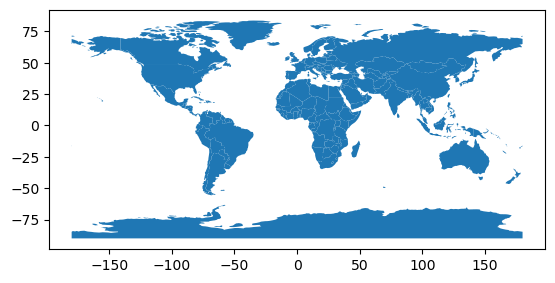

In [11]:
borders = gpd.read_file('../_data/world_data/world_borders.geojson')
borders.plot()

In [12]:
# merge into one mega-world-spanning polygon
world_polygon = borders.geometry.unary_union
world = gpd.GeoDataFrame(geometry=[world_polygon], crs=borders.crs)
world.to_parquet('../_data/world_data/world_polygon.parquet', engine='pyarrow')

/Applications/Anaconda/anaconda3/envs/lego/lib/python3.10/site-packages/shapely/set_operations.py:421: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


<Figure size 640x480 with 0 Axes>

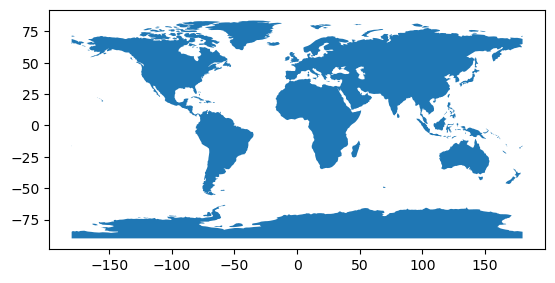

In [13]:
world = gpd.read_parquet('../_data/world_data/world_polygon.parquet')
plt.figure()
world.plot()

plt.savefig('figures/world_polygon.jpg',bbox_inches='tight')

In [56]:
# confirm cell size and dimensions of shape
# Path to the GeoParquet file
file_path = '../_data/world_data/world_polygon.parquet'

# Load the GeoParquet file into a GeoDataFrame
gdf = gpd.read_parquet(file_path)

# Calculate the bounding box of the polygon
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds

# Calculate dimensions of the bounding box
width = maxx - minx
height = maxy - miny

# Calculate aspect ratio
aspect_ratio = width / height

# Print the results
print(f"Bounding box: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")
print(f"Width: {width}")
print(f"Height: {height}")
print(f"Aspect ratio: {aspect_ratio:.2f} ({'landscape' if aspect_ratio > 1 else 'portrait' if aspect_ratio < 1 else 'square'})")

Bounding box: minx=-180.0, miny=-90.0, maxx=180.0, maxy=83.64513
Width: 360.0
Height: 173.64513
Aspect ratio: 2.07 (landscape)


### Transform polygon of world shorelines to be in 2:1 aspect ratio

Since the polygon is not an exact 2:1 ratio, I will transform it using shapely.

In [61]:
# Path to the GeoParquet file
file_path = '../_data/world_data/world_polygon.parquet'

# Load the GeoParquet file
gdf = gpd.read_parquet(file_path)

# Calculate the current bounding box and aspect ratio
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds
current_width = maxx - minx
current_height = maxy - miny
current_aspect_ratio = current_width / current_height

# Desired aspect ratio
desired_aspect_ratio = 2.00

# Calculate scaling factors
if current_aspect_ratio > desired_aspect_ratio:
    # Landscape: Compress width
    scale_x = desired_aspect_ratio / current_aspect_ratio
    scale_y = 1  # No change in height
else:
    # Portrait: Stretch height
    scale_x = 1  # No change in width
    scale_y = current_aspect_ratio / desired_aspect_ratio

# Apply the scaling transformation
gdf['geometry'] = gdf['geometry'].apply(lambda geom: scale(geom, xfact=scale_x, yfact=scale_y, origin='center'))

# Save the transformed GeoDataFrame (optional)
output_path = '../_data/world_data/world_polygon_transformed.parquet'
gdf.to_parquet(output_path)

# Recalculate the bounding box and aspect ratio for verification
new_bounds = gdf.total_bounds
new_minx, new_miny, new_maxx, new_maxy = new_bounds
new_width = new_maxx - new_minx
new_height = new_maxy - new_miny
new_aspect_ratio = new_width / new_height

# Print results
print(f"Original aspect ratio: {current_aspect_ratio:.2f}")
print(f"Transformed aspect ratio: {new_aspect_ratio:.2f}")
print(f"Saved transformed GeoParquet to: {output_path}")

Original aspect ratio: 2.07
Transformed aspect ratio: 2.00
Saved transformed GeoParquet to: ../_data/world_data/world_polygon_transformed.parquet


<Figure size 640x480 with 0 Axes>

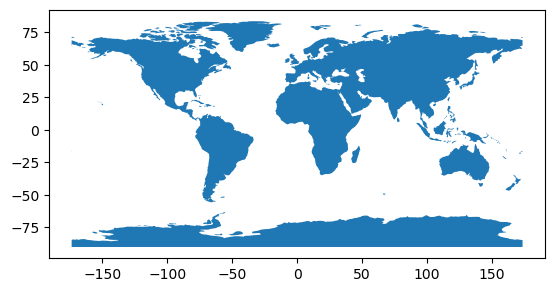

In [62]:
world_t = gpd.read_parquet('../_data/world_data/world_polygon_transformed.parquet')
plt.figure()
world_t.plot()

plt.savefig('figures/world_polygon_transformed.jpg',bbox_inches='tight')

Milan made a function that split the polygon into a grid with a user-specified number of cells. We may have to adapt it as our world map is not a square.

In [14]:
# Create the grid polygons
def create_grid(minx, miny, maxx, maxy, num_cells_x, num_cells_y):
    grid_polygons = []
    cell_width = (maxx - minx) / num_cells_x
    cell_height = (maxy - miny) / num_cells_y

    for i in range(num_cells_x):
        for j in range(num_cells_y):
            x = minx + i * cell_width
            y = miny + j * cell_height
            grid_polygons.append(box(x, y, x + cell_width, y + cell_height))
    
    return grid_polygons

In [15]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
world_t.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [69]:
# extract the bounding box of the world from the GeoDataFrame
bounds = world.bounds

minx = bounds.minx.values[0]
miny = bounds.miny.values[0]
maxx = bounds.maxx.values[0]
maxy = bounds.maxy.values[0]

We'll have to figure out what the dimensions of the Lego set are (in Lego studs), as that is a good size for our eventual Lego map.
* The map is $5 x 16 \text{ or } 80\text{ studs }$in height
* The map is $8 x 16 \text{ or } 128\text{ studs }$in width

That being said, the resulting map will be stretched; for example, Africa in the above dimensions will appear needlessly long. I prefer 80 x 160 as the aspect ratio (2:1) is what we expect from typical world maps.

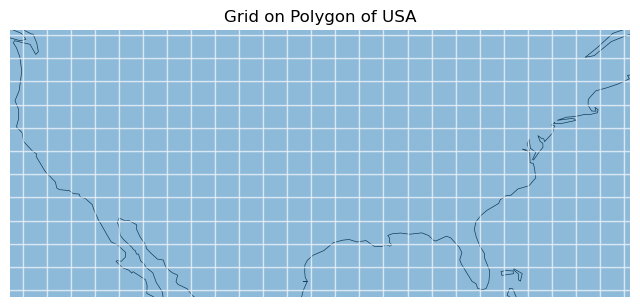

In [70]:
# Create a user-defined grid within the bounding box of the world
height = 80
width = 160
grid_crs = world.crs.to_epsg()
grid_polygons = create_grid(minx, miny, maxx, maxy, width, height)
gdf_grid = gpd.GeoDataFrame(grid_polygons, columns=['geometry'])
gdf_grid.crs = grid_crs

# Visualize the grid overlaid on the map
f, ax = plt.subplots(1, 1, figsize=(8, 8))
world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
gdf_grid.plot(ax=ax, edgecolor='w', alpha=0.5)
ax.axis('off')

# just view USA for now
ax.set_xlim(-125, -66.9)
ax.set_ylim(24.4, 49.4)

plt.title('Grid on Polygon of USA')

plt.savefig('figures/grid_usa.jpg',bbox_inches='tight')
plt.savefig('figures/grid_usa.pdf',bbox_inches='tight')
plt.savefig('figures/grid_usa.png',bbox_inches='tight')

plt.show()

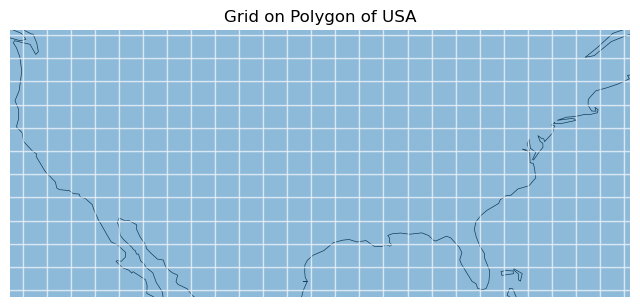

In [71]:
# extract the bounding box of the world from the GeoDataFrame
bounds = world_t.bounds

minx = bounds.minx.values[0]
miny = bounds.miny.values[0]
maxx = bounds.maxx.values[0]
maxy = bounds.maxy.values[0]

# Create a user-defined grid within the bounding box of the world
height = 80
width = 160
grid_crs = world_t.crs.to_epsg()
grid_polygons = create_grid(minx, miny, maxx, maxy, width, height)
gdf_grid_t = gpd.GeoDataFrame(grid_polygons, columns=['geometry'])
gdf_grid.crs = grid_crs

# Visualize the grid overlaid on the map
f, ax = plt.subplots(1, 1, figsize=(8, 8))
world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
gdf_grid.plot(ax=ax, edgecolor='w', alpha=0.5)
ax.axis('off')

# just view USA for now
ax.set_xlim(-125, -66.9)
ax.set_ylim(24.4, 49.4)

plt.title('Grid on Polygon of USA')

plt.savefig('figures/grid_usa_transformed.jpg',bbox_inches='tight')
plt.savefig('figures/grid_usa_transformed.pdf',bbox_inches='tight')
plt.savefig('figures/grid_usa_transformed.png',bbox_inches='tight')

plt.show()

### What about square grids with diagonal cross-lines?


That would allow us to have 45-degree shapes in addition to the 90-degree shapes of "pixelly" Lego.

We will modify the above code to include X's.

In [18]:
# Function to create the grid polygons and diagonal lines
def create_grid_with_x(minx, miny, maxx, maxy, num_cells_x, num_cells_y):
    grid_polygons = []
    cross_lines = []
    cell_width = (maxx - minx) / num_cells_x
    cell_height = (maxy - miny) / num_cells_y

    for i in range(num_cells_x):
        for j in range(num_cells_y):
            x = minx + i * cell_width
            y = miny + j * cell_height
            # Create the square polygon
            grid_polygons.append(box(x, y, x + cell_width, y + cell_height))
            
            # Create the diagonal cross-lines ("X")
            top_left = (x, y + cell_height)
            bottom_right = (x + cell_width, y)
            top_right = (x + cell_width, y + cell_height)
            bottom_left = (x, y)
            
            # Add the two diagonal lines
            cross_lines.append(LineString([top_left, bottom_right]))
            cross_lines.append(LineString([top_right, bottom_left]))

    return grid_polygons, cross_lines

In [19]:
# extract the bounding box of the world from the GeoDataFrame
bounds = world.bounds
minx = bounds.minx.values[0]
miny = bounds.miny.values[0]
maxx = bounds.maxx.values[0]
maxy = bounds.maxy.values[0]

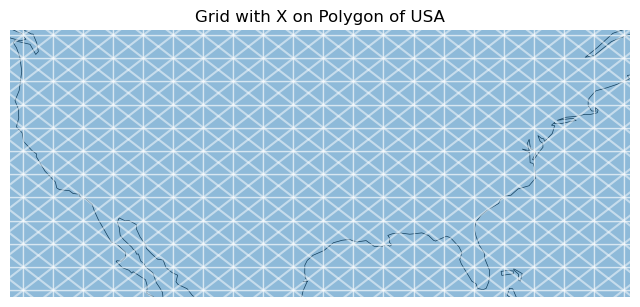

In [20]:
# create a user-defined grid within the bounding box of the world
height = 80
width = 128
grid_x_crs = world.crs.to_epsg()
grid_x_polygons, cross_lines = create_grid_with_x(minx, miny, maxx, maxy, width, height)

# create GeoDataFrames for the grid and diagonal lines
gdf_x_grid = gpd.GeoDataFrame({'geometry': grid_x_polygons})
gdf_x_grid.crs = grid_x_crs

gdf_x_lines = gpd.GeoDataFrame({'geometry': cross_lines})
gdf_x_lines.crs = grid_x_crs

# visualize the grid and cross-lines overlaid on the map
f, ax = plt.subplots(1, 1, figsize=(8, 8))
world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
gdf_x_grid.plot(ax=ax, edgecolor='w', alpha=0.5)
gdf_x_lines.plot(ax=ax, edgecolor='w', alpha=0.5)
ax.axis('off')

# zoom into the USA
ax.set_xlim(-125, -66.9)
ax.set_ylim(24.4, 49.4)

plt.title('Grid with X on Polygon of USA')

plt.savefig('figures/grid_x_usa.jpg', bbox_inches='tight')
plt.savefig('figures/grid_x_usa.pdf', bbox_inches='tight')
plt.savefig('figures/grid_x_usa.png', bbox_inches='tight')

plt.show()

## Create grid, extract to mask, compute zonal statistics

The earth has 360 degrees in total width and 180 degrees in total height. The grid cellsize will be the following, with a figure that has 160 x 80 grid cells:  
* 360/160 = 2.25
* 180/80 = 2.25

Therefore, each grid cell will be 2.25 degrees square.

Grid saved to: ../_data/world_data/world_grid.geojson
Zonal statistics saved to: ../_data/world_data/world_zonal_stats.geojson


<Axes: >

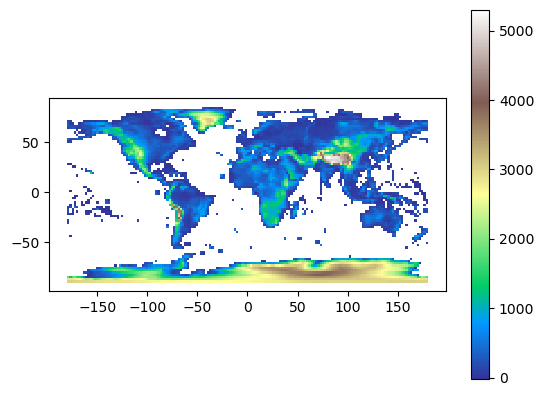

In [82]:
# File paths
input_dem = '../_data/world_data/dem_world_gtopo30.tiff'
output_grid = '../_data/world_data/world_grid.geojson'
output_stats = '../_data/world_data/world_zonal_stats.geojson'

# Define the grid resolution (degrees per cell)
grid_size = 2.25  # Adjust as needed (2° x 2° cells)

# Step 1: Create a uniform grid
def create_grid(extent, grid_size):
    minx, miny, maxx, maxy = extent
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    polygons = [
        box(x, y, x + grid_size, y + grid_size)
        for x in x_coords for y in y_coords
    ]
    grid = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:4326')
    return grid

# Read DEM to get its bounds
with rasterio.open(input_dem) as src:
    dem_bounds = src.bounds  # (minx, miny, maxx, maxy)

# Create the grid
grid = create_grid(dem_bounds, grid_size)
grid.to_file(output_grid, driver='GeoJSON')
print(f"Grid saved to: {output_grid}")

# Step 2: Calculate zonal statistics (mean elevation per grid cell)
zonal_stats_result = zonal_stats(
    grid, input_dem, stats=['mean'], geojson_out=True
)

# Convert results to GeoDataFrame
zonal_stats_gdf = gpd.GeoDataFrame.from_features(zonal_stats_result, crs='EPSG:4326')

# Save results
zonal_stats_gdf.to_file(output_stats, driver='GeoJSON')
print(f"Zonal statistics saved to: {output_stats}")

# Step 3: Visualize (Optional)
zonal_stats_gdf.plot(column='mean', cmap='terrain', legend=True)


### Discretize elevation

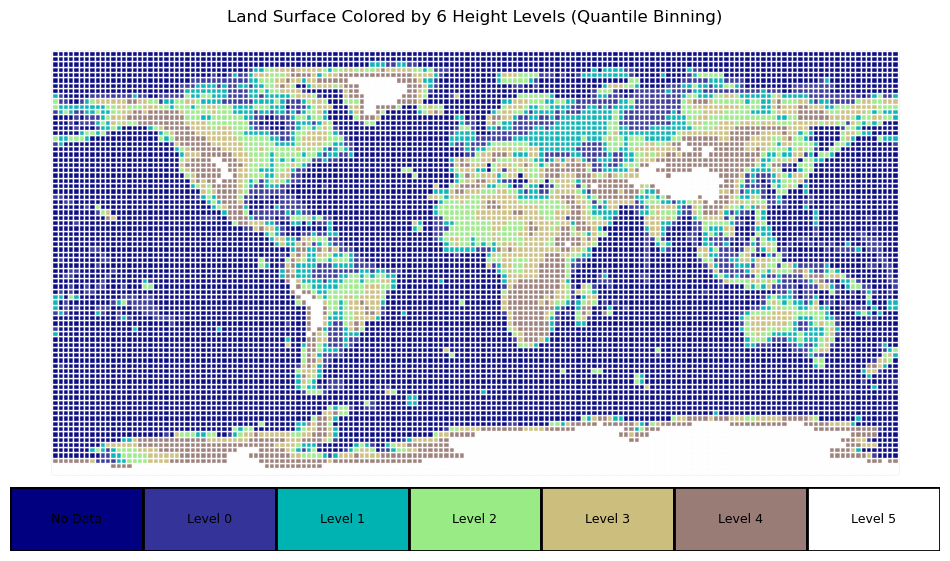

In [90]:
# Load the previously created GeoJSON with zonal statistics
input_stats = '../_data/world_data/world_zonal_stats.geojson'
gdf_grid = gpd.read_file(input_stats)

# Number of levels (user-defined)
n_levels = 6

# Custom RGBA color for areas with no data
no_data_color = [0, 0, 0.5, 1]  # Dark blue (RGBA)

# Step 1: Add a no-data mask
gdf_grid['height_level'] = -1  # Initialize all values as "-1" for no data
gdf_grid.loc[gdf_grid['mean'].notna(), 'height_level'] = 0  # Temporary placeholder

# Step 2: Filter for valid elevation data
valid_data = gdf_grid['mean'].notna()
gdf_valid = gdf_grid[valid_data].copy()

# Step 3: Apply quantile binning to redistribute valid data into levels
gdf_valid['height_level'] = pd.qcut(
    gdf_valid['mean'], 
    q=n_levels, 
    labels=range(n_levels)
).astype(int)

# Update the original GeoDataFrame with binned values
gdf_grid.loc[valid_data, 'height_level'] = gdf_valid['height_level']

# Step 4: Define the colormap
terrain_colors = cm.terrain(np.linspace(0, 1, n_levels))  # Colormap for valid data
cmap = mcolors.ListedColormap([no_data_color] + list(terrain_colors))  # Include no-data color

# Step 5: Visualization setup
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[15, 1])

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Plot base grid with grey edges
gdf_grid.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot grid colored by height levels
gdf_grid.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95,
    categorical=True
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

# --- Custom Color Bar ---
ax_cbar = fig.add_subplot(gs[1])
fig.subplots_adjust(hspace=-0.5)

# Create swatches for color bar
for i in range(-1, n_levels):
    rect_color = no_data_color if i == -1 else terrain_colors[i]
    label_text = "No Data" if i == -1 else f"Level {i}"
    
    ax_cbar.add_patch(
        plt.Rectangle(
            ((i + 1) / (n_levels + 1), 0),
            1 / (n_levels + 1),
            1,
            facecolor=rect_color,
            edgecolor='black',
            linewidth=2
        )
    )
    ax_cbar.text(
        ((i + 1.5) / (n_levels + 1)), 0.5,
        label_text,
        ha='center', va='center', color='black', fontsize=9
    )

ax_cbar.set_xlim(0, 1)
ax_cbar.set_ylim(0, 1)
ax_cbar.axis('off')

# Save the plot in various formats
output_folder = 'figures'
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.png', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.jpg', bbox_inches='tight')

plt.show()

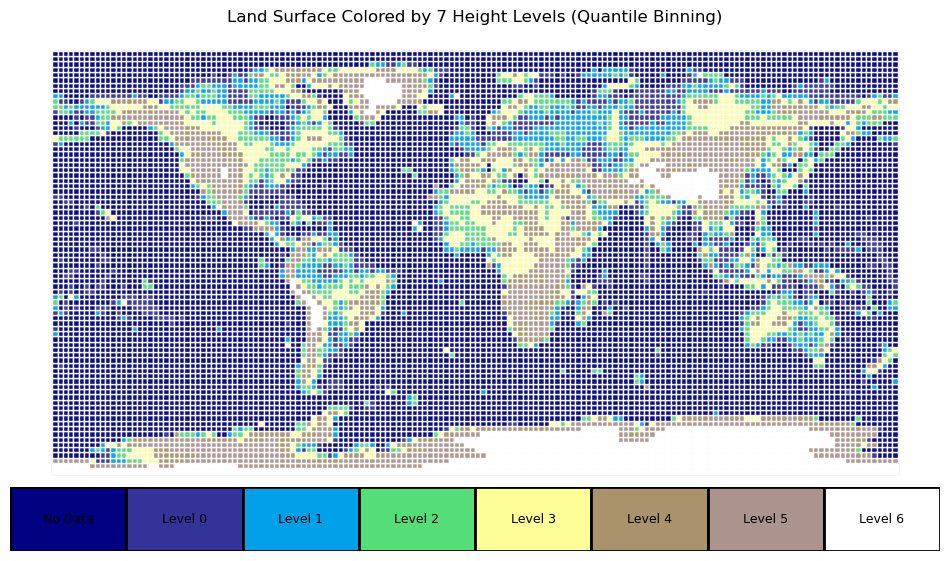

In [ ]:
# Load the previously created GeoJSON with zonal statistics
input_stats = '../_data/world_data/world_zonal_stats.geojson'
gdf_grid = gpd.read_file(input_stats)

# Number of levels (user-defined)
n_levels = 7

# Custom RGBA color for areas with no data
no_data_color = [0, 0, 0.5, 1]  # Dark blue (RGBA)

# Step 1: Add a no-data mask
gdf_grid['height_level'] = -1  # Initialize all values as "-1" for no data
gdf_grid.loc[gdf_grid['mean'].notna(), 'height_level'] = 0  # Temporary placeholder

# Step 2: Filter for valid elevation data
valid_data = gdf_grid['mean'].notna()
gdf_valid = gdf_grid[valid_data].copy()

# Step 3: Apply quantile binning to redistribute valid data into levels
gdf_valid['height_level'] = pd.qcut(
    gdf_valid['mean'], 
    q=n_levels, 
    labels=range(n_levels)
).astype(int)

# Update the original GeoDataFrame with binned values
gdf_grid.loc[valid_data, 'height_level'] = gdf_valid['height_level']

# Step 4: Define the colormap
terrain_colors = cm.terrain(np.linspace(0, 1, n_levels))  # Colormap for valid data
cmap = mcolors.ListedColormap([no_data_color] + list(terrain_colors))  # Include no-data color

# Step 5: Visualization setup
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[15, 1])

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Plot base grid with grey edges
gdf_grid.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot grid colored by height levels
gdf_grid.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95,
    categorical=True
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

# --- Custom Color Bar ---
ax_cbar = fig.add_subplot(gs[1])
fig.subplots_adjust(hspace=-0.5)

# Create swatches for color bar
for i in range(-1, n_levels):
    rect_color = no_data_color if i == -1 else terrain_colors[i]
    label_text = "No Data" if i == -1 else f"Level {i}"
    
    ax_cbar.add_patch(
        plt.Rectangle(
            ((i + 1) / (n_levels + 1), 0),
            1 / (n_levels + 1),
            1,
            facecolor=rect_color,
            edgecolor='black',
            linewidth=2
        )
    )
    ax_cbar.text(
        ((i + 1.5) / (n_levels + 1)), 0.5,
        label_text,
        ha='center', va='center', color='black', fontsize=9
    )

ax_cbar.set_xlim(0, 1)
ax_cbar.set_ylim(0, 1)
ax_cbar.axis('off')

# Save the plot in various formats
output_folder = 'figures'
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.png', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.jpg', bbox_inches='tight')

plt.show()

TypeError: Image data of dtype object cannot be converted to float

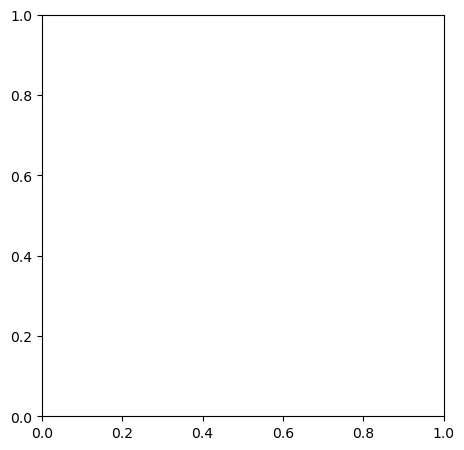

In [99]:
# Load the previously created GeoJSON with zonal statistics
input_stats = '../_data/world_data/world_zonal_stats.geojson'
gdf_grid = gpd.read_file(input_stats)

# Number of levels (user-defined)
n_levels = 10

# Custom RGBA color for areas with no data
no_data_color = [0, 0, 0.5, 1]  # Dark blue (RGBA)

# Step 1: Add a no-data mask
gdf_grid['height_level'] = -1  # Initialize all values as "-1" for no data
gdf_grid.loc[gdf_grid['mean'].notna(), 'height_level'] = 0  # Temporary placeholder

# Step 2: Filter for valid elevation data
valid_data = gdf_grid['mean'].notna()
gdf_valid = gdf_grid[valid_data].copy()

# Step 3: Apply quantile binning to redistribute valid data into levels
gdf_valid['height_level'] = pd.qcut(
    gdf_valid['mean'], 
    q=n_levels, 
    labels=range(n_levels)
).astype(int)

# Update the original GeoDataFrame with binned values
gdf_grid.loc[valid_data, 'height_level'] = gdf_valid['height_level']

# Step 4: Define the colormap
terrain_colors = cm.terrain(np.linspace(0, 1, n_levels))  # Colormap for valid data
cmap = mcolors.ListedColormap([no_data_color] + list(terrain_colors))  # Include no-data color

# Step 5: Visualization setup
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(gdf_grid)
ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

# Plot base grid with grey edges
gdf_grid.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot grid colored by height levels
gdf_grid.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95,
    categorical=True
)

ax_main.axis('off')

# --- Color Swatches ---
gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors), subplot_spec=gs[1, 0], wspace=0.2)
for idx, (color, hex_color) in enumerate(zip(unique_colors, hex_colors)):
    if idx == 0:
        elevation_interval = f"{gdf_valid['mean'].quantile((idx - 1) / n_levels):.1f} - {gdf_valid['mean'].quantile(idx / n_levels):.1f} m"
    else:
        elevation_interval = 'Ocean'
    ax_swatch = fig.add_subplot(gs_swatch[0, idx])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')  # Remove axes, ticks, etc.
    ax_swatch.text((idx + 1) / n_levels + 1, 0.5, f'''Level {i - 1}\n
        {elevation_interval}\n
        {level_counts.get(idx - 1, 0)} cells\n
        HEX: {mcolors.to_hex(rect_color)}''',
        fontsize=8,
        pad=5,
        ha='center',
        va='center',
        color='black'
    )

fig.subplots_adjust(hspace=0.1)

ax_swatches.set_xlim(0, 1)
ax_swatches.set_ylim(0, 1)
ax_swatches.axis('off')

# Save the plot in various formats
output_folder = 'figures'
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.png', bbox_inches='tight')
plt.savefig(f'{output_folder}/elevation_with_{n_levels}.jpg', bbox_inches='tight')

plt.show()

### Testing one two three

## Map elevation values into the grid

### With square grid:

In [21]:
file_path='../_data/world_data/dem_world_gtopo30.tiff'

# open GeoTIFF file
with rio.open(file_path) as src:
    print('Number of bands:', src.count)
    print('CRS:', src.crs)
    print('Bounds:', src.bounds)
    print('Metadata:', src.meta)
    print('Description:', src.descriptions)
    
    # check descriptions and statistics of each band
    for band in range(1, src.count + 1):
        print(f"Band {band} description: {src.descriptions[band-1]}")
        data = src.read(band)
        print(f"Band {band} min value: {data.min()}, max value: {data.max()}")

Number of bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-89.99999999992801, right=179.99999999985602, top=90.0)
Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333333333, 0.0, -180.0,
       0.0, -0.00833333333333, 90.0)}
Description: (None,)
Band 1 description: None
Band 1 min value: -9999, max value: 8752


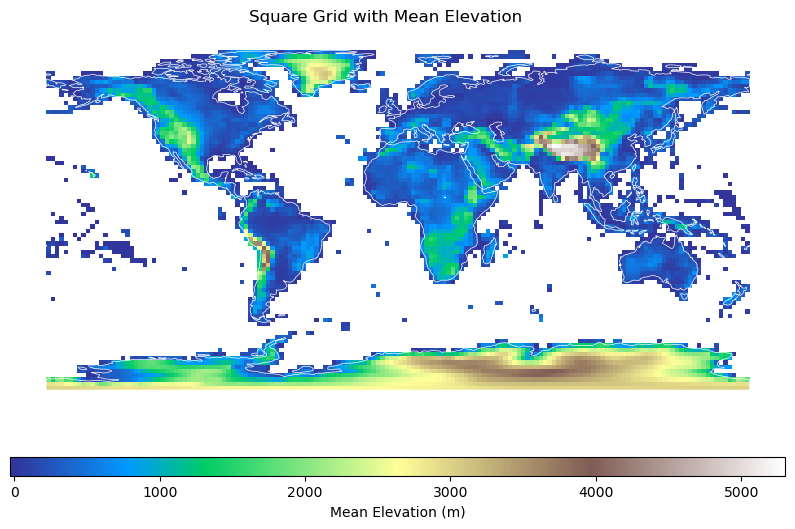

In [22]:
# compute zonal statistics for the grid cells based on elevation data
with rio.open(file_path) as src:
    # use zonal_stats to calculate mean elevation for each grid cell
    stats = zonal_stats(
        gdf_grid,                     # grid polygons
        src.read(1),                  # elevation data (band 1)
        affine=src.transform,         # geoTIFF affine transform
        stats=["mean"],               # compute mean elevation
        nodata=src.nodatavals[0]      # ignore nodata values
    )

# extract the mean elevation for each grid cell
gdf_grid["elevation_mean"] = [stat["mean"] for stat in stats]

# inspect the updated grid with elevation data
# print(gdf_grid.head())

# visualize the grid with elevation values
f, ax = plt.subplots(1, 1, figsize=(10, 10))

# define a color map and normalization for the data
cmap = plt.cm.terrain  # color map
vmin = gdf_grid["elevation_mean"].min()
vmax = gdf_grid["elevation_mean"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# plot the grid with elevation data using the defined color map
gdf_grid.plot(
    ax=ax,
    column="elevation_mean",
    cmap=cmap,
    edgecolor="none"
)

world.plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)

# create a divider for placing the color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# add the color bar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # dummy array for ScalarMappable
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Mean Elevation (m)")

ax.axis("off")
plt.suptitle("Square Grid with Mean Elevation", y=0.74)

plt.savefig('figures/square_grid_with_elevation.pdf', bbox_inches='tight')
plt.savefig('figures/square_grid_with_elevation.jpg', bbox_inches='tight')
plt.savefig('figures/square_grid_with_elevation.png', bbox_inches='tight')

plt.show()

### With square, transformed grid:

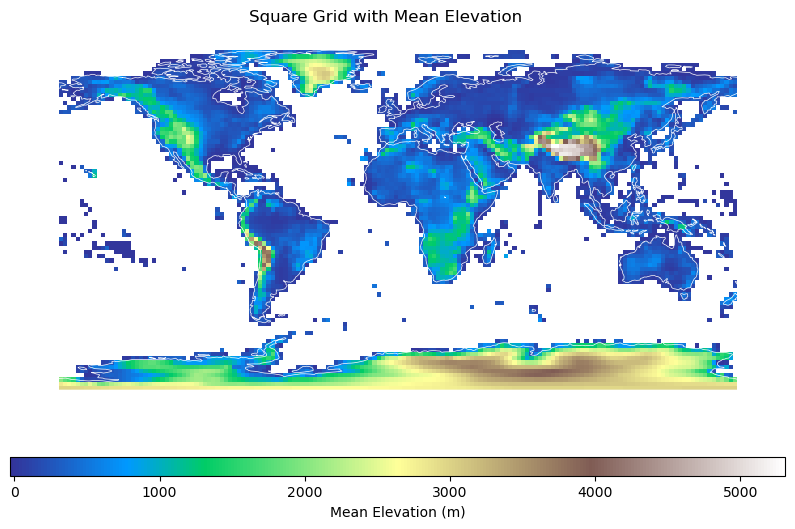

In [74]:
file_path = '../_data/world_data/dem_world_gtopo30.tiff'

# compute zonal statistics for the grid cells based on elevation data
with rio.open(file_path) as src:
    # use zonal_stats to calculate mean elevation for each grid cell
    stats = zonal_stats(
        gdf_grid_t,                    # grid polygons
        src.read(1),                  # elevation data (band 1)
        affine=src.transform,         # geoTIFF affine transform
        stats=["mean"],               # compute mean elevation
        nodata=src.nodatavals[0]      # ignore nodata values
    )

# extract the mean elevation for each grid cell
gdf_grid_t["elevation_mean"] = [stat["mean"] for stat in stats]

# inspect the updated grid with elevation data
# print(gdf_grid_t.head())

# visualize the grid with elevation values
f, ax = plt.subplots(1, 1, figsize=(10, 10))

# define a color map and normalization for the data
cmap = plt.cm.terrain  # color map
vmin = gdf_grid_t["elevation_mean"].min()
vmax = gdf_grid_t["elevation_mean"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# plot the grid with elevation data using the defined color map
gdf_grid_t.plot(
    ax=ax,
    column="elevation_mean",
    cmap=cmap,
    edgecolor="none"
)

world.plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)

# create a divider for placing the color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# add the color bar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # dummy array for ScalarMappable
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Mean Elevation (m)")

ax.axis("off")
plt.suptitle("Square Grid with Mean Elevation", y=0.74)

plt.savefig('figures/square_grid_with_elevation_transformed.pdf', bbox_inches='tight')
plt.savefig('figures/square_grid_with_elevation_transformed.jpg', bbox_inches='tight')
plt.savefig('figures/square_grid_with_elevation_transformed.png', bbox_inches='tight')

plt.show()

### With square-X grid:

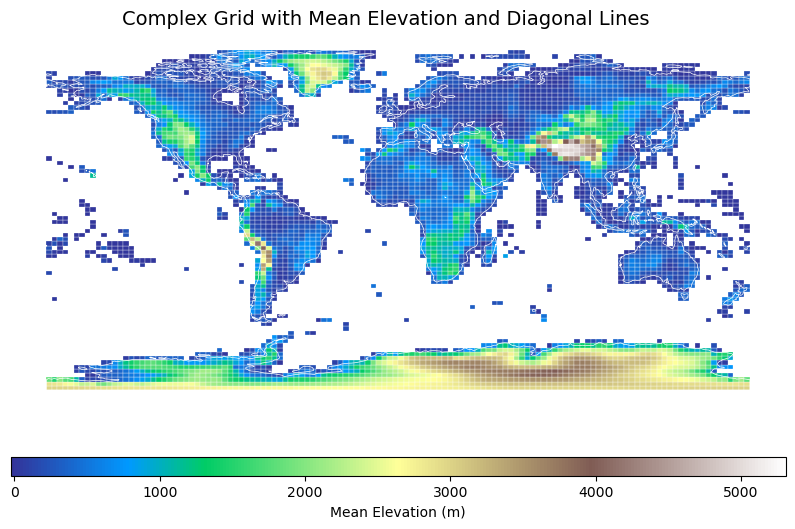

In [23]:
# compute zonal statistics for the grid cells based on elevation data
with rio.open(file_path) as src:
    # use zonal_stats to calculate mean elevation for each grid cell
    stats = zonal_stats(
        gdf_x_grid,                     # grid polygons
        src.read(1),                  # elevation data (band 1)
        affine=src.transform,         # geoTIFF affine transform
        stats=["mean"],               # compute mean elevation
        nodata=src.nodatavals[0]      # ignore nodata values
    )

# extract the mean elevation for each grid cell
gdf_x_grid["elevation_mean"] = [stat["mean"] for stat in stats]

# inspect the updated grid with elevation data
# print(gdf_grid.head())

# visualize the grid with elevation values and diagonal lines
f, ax = plt.subplots(1, 1, figsize=(10, 10))

# define a color map and normalization for the data
cmap = plt.cm.terrain  # color map
vmin = gdf_x_grid["elevation_mean"].min()
vmax = gdf_x_grid["elevation_mean"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# plot the grid with elevation data using the defined color map
gdf_x_grid.plot(
    ax=ax,
    column="elevation_mean",
    cmap=cmap,
    edgecolor="white",  # optional: white edges for clarity
    linewidth=0.2
)

# # plot the diagonal lines on top of the grid
# gdf_x_lines.plot(ax=ax, edgecolor="w", alpha=0.5)

# add world boundaries for context
world.plot(ax=ax, color="none", edgecolor="white", linewidth=0.5)

# create a divider for placing the color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# add the color bar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # dummy array for ScalarMappable
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Mean Elevation (m)")

ax.axis("off")
f.suptitle("Complex Grid with Mean Elevation and Diagonal Lines", y=0.74, fontsize=14)

plt.show()

This did change the figure slightly, though it might not be worth the trouble. It will increase the precision but might also increase the Lego piece count.

We will focus on just the square grid.

## Discretize elevation

As a final step for encoding elevation into Lego, we need to discretize the height into levels, under 10 levels, so that our Lego map will show elevation.

Original grid size: 12800
Filtered grid size (land only): 5901
Height Level Min: 0
Height Level Max: 6


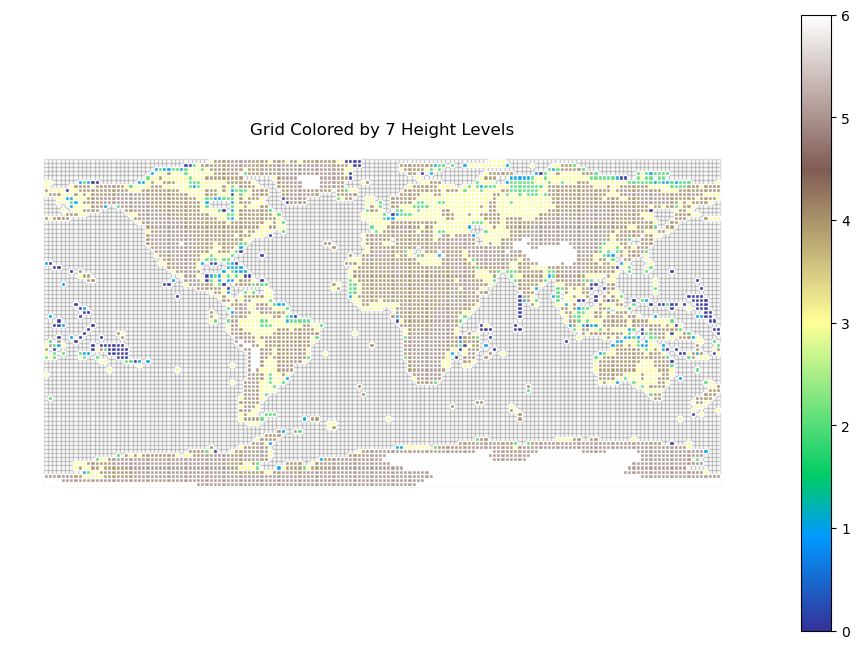

In [25]:
# number of levels you want to display
n_levels = 7  # Set this to 5, 6, 7, or any desired number of levels

# step 1: filter out very low elevation values (e.g., below sea level)
threshold = 1  # elevation threshold (set to X meters)
gdf_land = gdf_grid[gdf_grid['elevation_mean'] >= threshold].copy()

print(f"Original grid size: {len(gdf_grid)}")
print(f"Filtered grid size (land only): {len(gdf_land)}")

# step 2: logarithmic transformation with error handling
gdf_land['log'] = gdf_land['elevation_mean'].apply(lambda x: math.log(x + 1) if not np.isnan(x) else np.nan)

# step 3: scaling values to the desired number of levels
val_min = gdf_land['log'].min()
val_max = gdf_land['log'].max()

# normalize the values to range [0, n_levels-1]
gdf_land['height_level'] = gdf_land['log'].apply(
    lambda v: round((v - val_min) / (val_max - val_min) * (n_levels - 1)) if not np.isnan(v) else np.nan
)

# step 4: print stats (Optional)
print("Height Level Min:", gdf_land['height_level'].min())
print("Height Level Max:", gdf_land['height_level'].max())

# step 4: visualization
f, ax = plt.subplots(1, 1, figsize=(12, 8))

# base grid with grey edges
gdf_grid.plot(ax=ax, color='w', edgecolor='grey', alpha=0.25)

# plot the grid colored by height levels
gdf_land.plot(
    ax=ax,
    column='height_level',
    edgecolor='w',
    cmap='terrain',  # Choose any colormap
    alpha=0.95,
    legend=True
)

ax.axis('off')
plt.title(f"Grid Colored by {n_levels} Height Levels")
plt.show()

In [ ]:
gdf_grid['elevation_mean'].describe()

count    5913.000000
mean      898.879608
std      1052.305098
min       -27.984972
25%       157.489130
50%       417.619088
75%      1251.564680
max      5303.856496
Name: elevation_mean, dtype: float64

This is not ideal. Most of the land surface appears to be at one elevation, which is not visually pleasing and doesn't show the change in elevation enough. We want a more exciting map.

The quantile binning method to enable a more balanced representation, so that each level gets an approximately equal share of the grid cells. It is also dynamically driven, so as the data changes, the thresholds will adapt.

### 6 levels

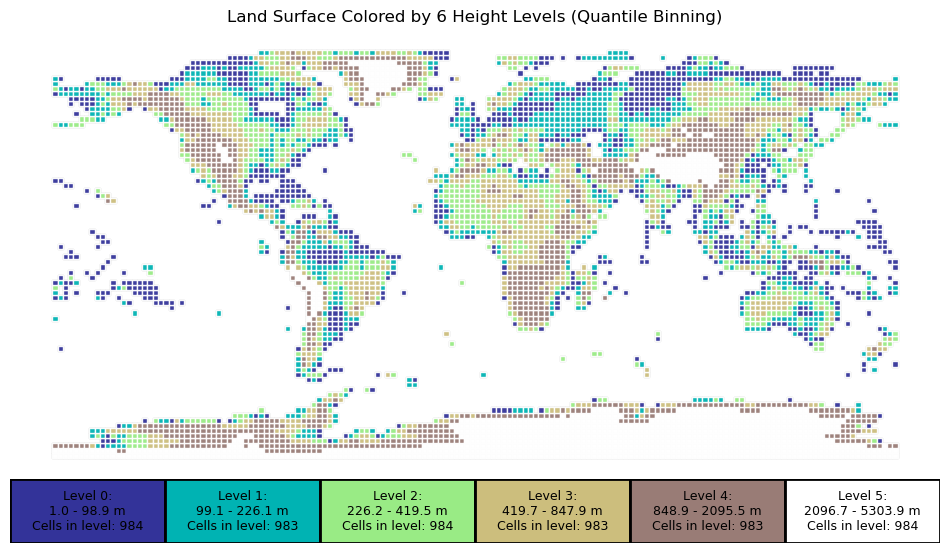

In [26]:
# Number of levels
n_levels = 6  # User-defined number of levels

# Step 1: Filter out ocean floors or very low elevations
threshold = 1  # 1 meter cutoff for land surface
gdf_land = gdf_grid[gdf_grid['elevation_mean'] >= threshold].copy()

# Step 2: Quantile binning to redistribute elevation data evenly across levels
gdf_land['height_level'] = pd.qcut(
    gdf_land['elevation_mean'],
    q=n_levels,
    labels=range(n_levels)
)

# Convert height levels to integers for better readability
gdf_land['height_level'] = gdf_land['height_level'].astype(int)

# Define custom colors for the levels using the terrain colormap
colors = plt.cm.terrain(np.linspace(0, 1, n_levels))
cmap = mcolors.ListedColormap(colors)

# Step 3: Visualization setup using GridSpec
fig = plt.figure(figsize=(12, 10))  # Adjust overall figure size
gs = fig.add_gridspec(2, 1, height_ratios=[15, 1])  # Tighten second row

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Base grid with grey edges
gdf_land.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot the grid colored by height levels
gdf_land.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

plt.savefig(f'figures/overview_elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'figures/overview_elevation_with_{n_levels}.png', bbox_inches='tight')
plt.savefig(f'figures/overview_elevation_with_{n_levels}.jpg', bbox_inches='tight')

# --- Custom Color Bar Subplot ---
ax_cbar = fig.add_subplot(gs[1])

# Reduce spacing between plots
fig.subplots_adjust(hspace=-0.5)  # Adjust spacing between GridSpec rows

# Add color swatches for each level
for i in range(n_levels):
    # Get the elevation range for the current level
    level_min = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].min()
    level_max = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].max()

    # Add a colored rectangle for each level with a black border
    ax_cbar.add_patch(
        plt.Rectangle(
            (i / n_levels, 0),  # position: (x, y) and width
            1 / n_levels,  # width of each swatch
            1,  # height of each swatch
            facecolor=colors[i],  # Fill color (facecolor)
            linewidth=2,  # Black border width
            edgecolor='black'  # Border color
        )
    )

    # Set title with level and its corresponding elevation range
    level_counts = gdf_land['height_level'].value_counts().sort_index()
    ax_cbar.text(
        (i + 0.5) / n_levels,  # X position for the text (centered)
        0.5,  # Y position for the text (vertically centered)
        f"Level {i}:\n{level_min:.1f} - {level_max:.1f} m\nCells in level: {level_counts[i]}", # textcontent
        ha='center', va='center', color='black', fontsize=9
    )

ax_cbar.set_xlim(0, 1)
ax_cbar.set_ylim(0, 1)
ax_cbar.axis('off')  # Hide the axis

plt.savefig(f'figures/elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}.jpg', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}.png', bbox_inches='tight')

plt.show()

#### With transformed grid

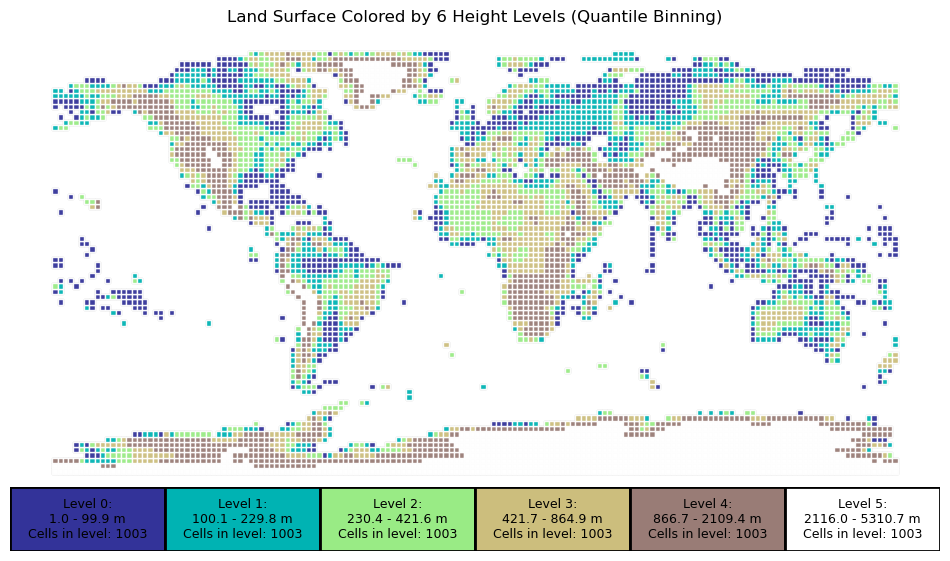

In [75]:
# Number of levels
n_levels = 6  # User-defined number of levels

# Step 1: Filter out ocean floors or very low elevations
threshold = 1  # 1 meter cutoff for land surface
gdf_land_t = gdf_grid_t[gdf_grid_t['elevation_mean'] >= threshold].copy()

# Step 2: Quantile binning to redistribute elevation data evenly across levels
gdf_land_t['height_level'] = pd.qcut(
    gdf_land_t['elevation_mean'],
    q=n_levels,
    labels=range(n_levels)
)

# Convert height levels to integers for better readability
gdf_land_t['height_level'] = gdf_land_t['height_level'].astype(int)

# Define custom colors for the levels using the terrain colormap
colors = plt.cm.terrain(np.linspace(0, 1, n_levels))
cmap = mcolors.ListedColormap(colors)

# Step 3: Visualization setup using GridSpec
fig = plt.figure(figsize=(12, 10))  # Adjust overall figure size
gs = fig.add_gridspec(2, 1, height_ratios=[15, 1])  # Tighten second row

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Base grid with grey edges
gdf_land_t.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot the grid colored by height levels
gdf_land_t.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

plt.savefig(f'figures/overview_elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'figures/overview_elevation_with_{n_levels}.png', bbox_inches='tight')
plt.savefig(f'figures/overview_elevation_with_{n_levels}.jpg', bbox_inches='tight')

# --- Custom Color Bar Subplot ---
ax_cbar = fig.add_subplot(gs[1])

# Reduce spacing between plots
fig.subplots_adjust(hspace=-0.5)  # Adjust spacing between GridSpec rows

# Add color swatches for each level
for i in range(n_levels):
    # Get the elevation range for the current level
    level_min = gdf_land_t[gdf_land_t['height_level'] == i]['elevation_mean'].min()
    level_max = gdf_land_t[gdf_land_t['height_level'] == i]['elevation_mean'].max()

    # Add a colored rectangle for each level with a black border
    ax_cbar.add_patch(
        plt.Rectangle(
            (i / n_levels, 0),  # position: (x, y) and width
            1 / n_levels,  # width of each swatch
            1,  # height of each swatch
            facecolor=colors[i],  # Fill color (facecolor)
            linewidth=2,  # Black border width
            edgecolor='black'  # Border color
        )
    )

    # Set title with level and its corresponding elevation range
    level_counts = gdf_land_t['height_level'].value_counts().sort_index()
    ax_cbar.text(
        (i + 0.5) / n_levels,  # X position for the text (centered)
        0.5,  # Y position for the text (vertically centered)
        f"Level {i}:\n{level_min:.1f} - {level_max:.1f} m\nCells in level: {level_counts[i]}", # textcontent
        ha='center', va='center', color='black', fontsize=9
    )

ax_cbar.set_xlim(0, 1)
ax_cbar.set_ylim(0, 1)
ax_cbar.axis('off')  # Hide the axis

plt.savefig(f'figures/elevation_with_{n_levels}_tranform.pdf', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}_tranform.jpg', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}_tranform.png', bbox_inches='tight')

plt.show()

In [76]:
gdf_grid_t['elevation_mean'].describe()

count    6029.000000
mean      903.732451
std      1053.519528
min       -27.999763
25%       160.421706
50%       420.218536
75%      1265.948276
max      5310.683328
Name: elevation_mean, dtype: float64

#### Save patches for building

In [30]:
print(gdf_land.shape)
print(gdf_land.columns)
print(gdf_land.bounds)

(5901, 3)
Index(['geometry', 'elevation_mean', 'height_level'], dtype='object')
         minx       miny    maxx       maxy
0     -180.00 -90.000000 -177.75 -87.829436
1     -180.00 -87.829436 -177.75 -85.658872
2     -180.00 -85.658872 -177.75 -83.488308
27    -180.00 -31.394769 -177.75 -29.224205
31    -180.00 -22.712512 -177.75 -20.541948
...       ...        ...     ...        ...
12790  177.75  61.939489  180.00  64.110053
12791  177.75  64.110053  180.00  66.280617
12792  177.75  66.280617  180.00  68.451181
12793  177.75  68.451181  180.00  70.621745
12794  177.75  70.621745  180.00  72.792309

[5901 rows x 4 columns]


In [46]:
print(gdf_land.head())

                                             geometry  elevation_mean  \
0   POLYGON ((-177.75000 -90.00000, -177.75000 -87...     2995.587906   
1   POLYGON ((-177.75000 -87.82944, -177.75000 -85...     2879.981142   
2   POLYGON ((-177.75000 -85.65887, -177.75000 -83...     1891.065443   
27  POLYGON ((-177.75000 -31.39477, -177.75000 -29...      145.354839   
31  POLYGON ((-177.75000 -22.71251, -177.75000 -20...       25.785714   

    height_level  
0              5  
1              5  
2              4  
27             1  
31             0  


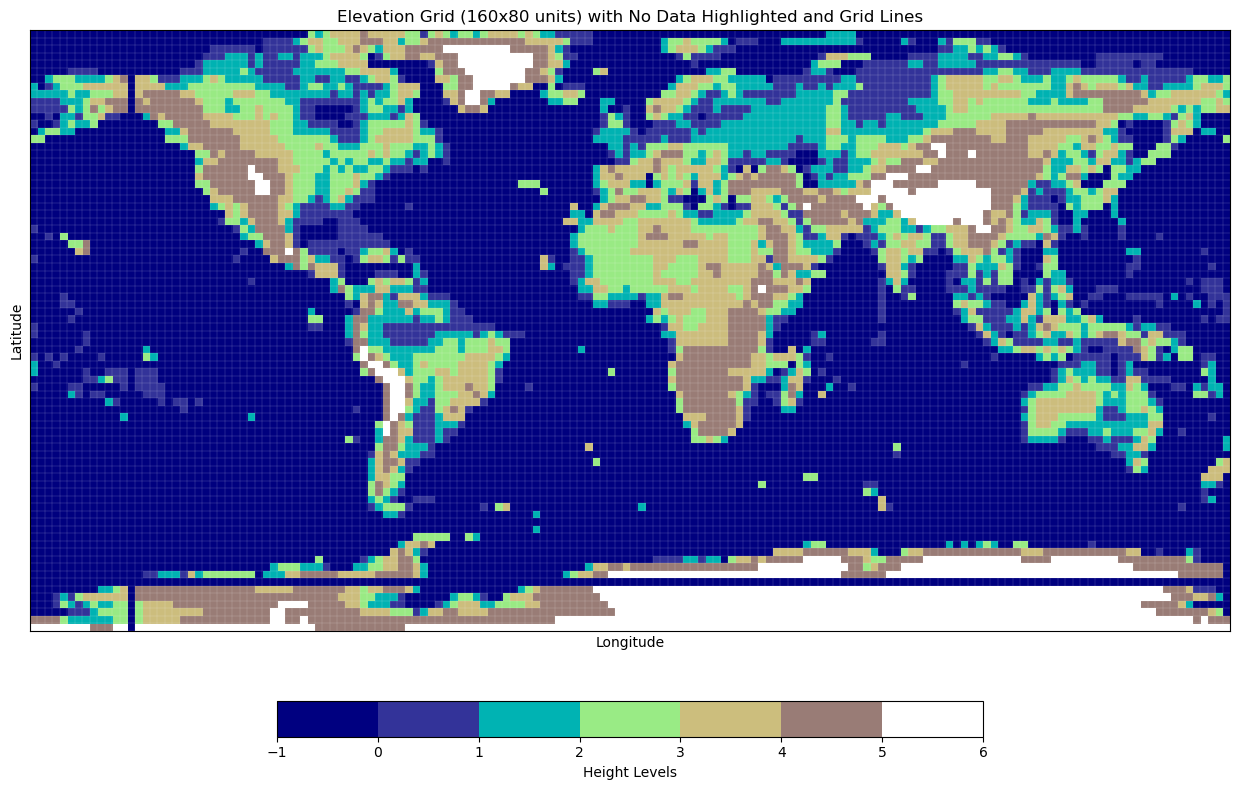

In [81]:
# Step 1: Define the grid dimensions and bounds
grid_width = 160
grid_height = 80

# Dataset bounds
minx, miny, maxx, maxy = gdf_land_t.total_bounds

# Compute the grid cell size
cell_width = (maxx - minx) / grid_width
cell_height = (maxy - miny) / grid_height

# Step 2: Create an empty grid for height levels
height_grid = np.full((grid_height, grid_width), -1)  # Fill with -1 for "no data"

# Step 3: Assign height levels to the grid
for _, row in gdf_land_t.iterrows():
    # Determine which grid cell the geometry falls into
    col = int((row.geometry.bounds[0] - minx) / cell_width)
    row_idx = int((row.geometry.bounds[1] - miny) / cell_height)
    
    # Ensure indices are within bounds
    col = min(max(col, 0), grid_width - 1)
    row_idx = min(max(row_idx, 0), grid_height - 1)
    
    # Assign the height level
    height_grid[row_idx, col] = row.height_level

# Step 4: Create a custom colormap
n_levels = 6  # Number of height levels
terrain_colors = plt.cm.terrain(np.linspace(0, 1, n_levels))  # Existing terrain colors
dark_blue = np.array([[0, 0, 0.5, 1]])  # RGBA for dark blue
all_colors = np.vstack((dark_blue, terrain_colors))  # Add dark blue as the first color
custom_cmap = mcolors.ListedColormap(all_colors)

# Normalize the data (account for -1 as "no data")
norm = mcolors.BoundaryNorm(boundaries=[-1, 0] + list(range(1, n_levels + 1)), ncolors=all_colors.shape[0])

# Step 5: Plot using imshow
fig, ax = plt.subplots(figsize=(16, 8))  # Aspect ratio matches 160x80
cax = ax.imshow(height_grid, cmap=custom_cmap, extent=[minx, maxx, miny, maxy], 
                origin='lower', norm=norm, interpolation='nearest')

# Add a colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Height Levels')

# Add grid lines
# Vertical lines
for x in np.arange(minx, maxx, cell_width):
    ax.axvline(x, color='white', linewidth=0.2, linestyle='-', alpha=0.5)

# Horizontal lines
for y in np.arange(miny, maxy, cell_height):
    ax.axhline(y, color='white', linewidth=0.2, linestyle='-', alpha=0.5)

# Hide tick labels
ax.set_xticks([])
ax.set_yticks([])

# Titles and axis adjustments
ax.set_title("Elevation Grid (160x80 units) with No Data Highlighted and Grid Lines")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.savefig("figures/elevation_grid_160x80_with_grid_lines.png", dpi=300, bbox_inches='tight')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'array'

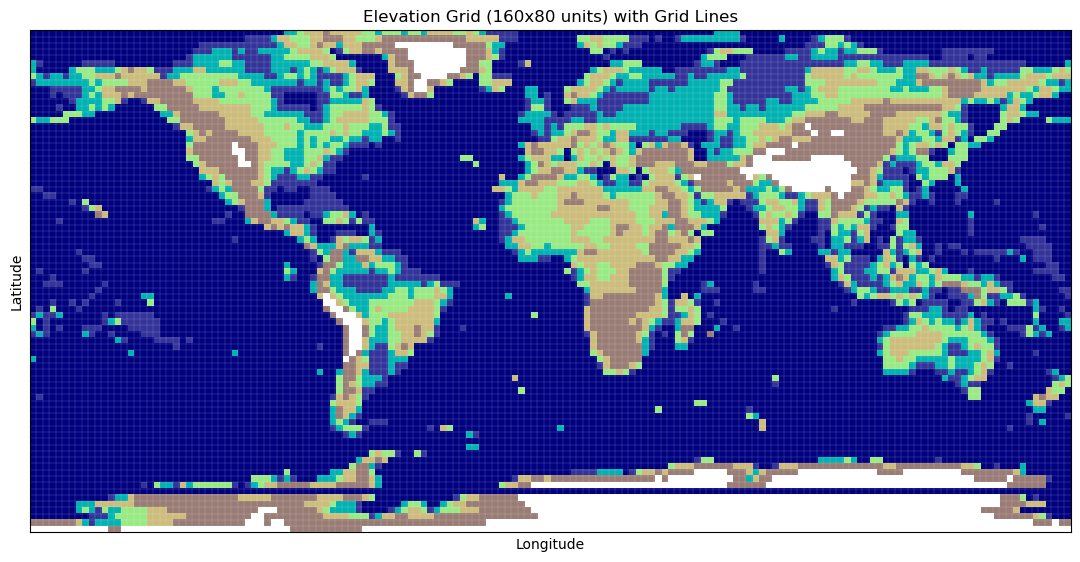

In [52]:
# Step 1: Create the main elevation grid plot
fig = plt.figure(figsize=(16, 10))  # Adjusted height for swatches
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

# Main plot
ax_main = fig.add_subplot(gs[0, 0])
cax = ax_main.imshow(
    height_grid,
    cmap=custom_cmap,
    extent=[minx, maxx, miny, maxy],
    origin="lower",
    norm=norm,
    interpolation="nearest"
)

# Grid lines
for x in np.arange(minx, maxx, cell_width):
    ax_main.axvline(x, color='white', linewidth=0.2, linestyle='-', alpha=0.5)
for y in np.arange(miny, maxy, cell_height):
    ax_main.axhline(y, color='white', linewidth=0.2, linestyle='-', alpha=0.5)

ax_main.set_xticks([])
ax_main.set_yticks([])
ax_main.set_title("Elevation Grid (160x80 units) with Grid Lines")
ax_main.set_xlabel("Longitude")
ax_main.set_ylabel("Latitude")

# Step 2: Generate color swatches
# Example swatches from the resized image
resized_array = mpimg.imread("figures/elevation_grid_160x80_with_grid_lines.png")
resized_array = resized_array.array()
# imgplot = plt.imshow(img)
# plt.axis('off')
# plt.show()

unique_colors, counts = np.unique(resized_array.reshape(-1, 3), axis=0, return_counts=True)
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# Subplots for swatches
ax_swatch_container = fig.add_subplot(gs[1, 0])
gs_swatch = GridSpec(1, len(unique_colors), subplot_spec=gs[1, 0], wspace=0.2)

for i, (color, hex_color, count) in enumerate(zip(unique_colors, hex_colors, counts)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')
    ax_swatch.set_title(f"ID: {i}\n{hex_color}\n{count} px", fontsize=8, pad=5)

# Adjust figure layout
plt.tight_layout()

# Save and display
# plt.savefig("figures/elevation_grid_with_swatches.png", dpi=300, bbox_inches="tight")
plt.show()

In [48]:
height_grid

array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 4,  4,  4, ...,  5,  4,  4],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

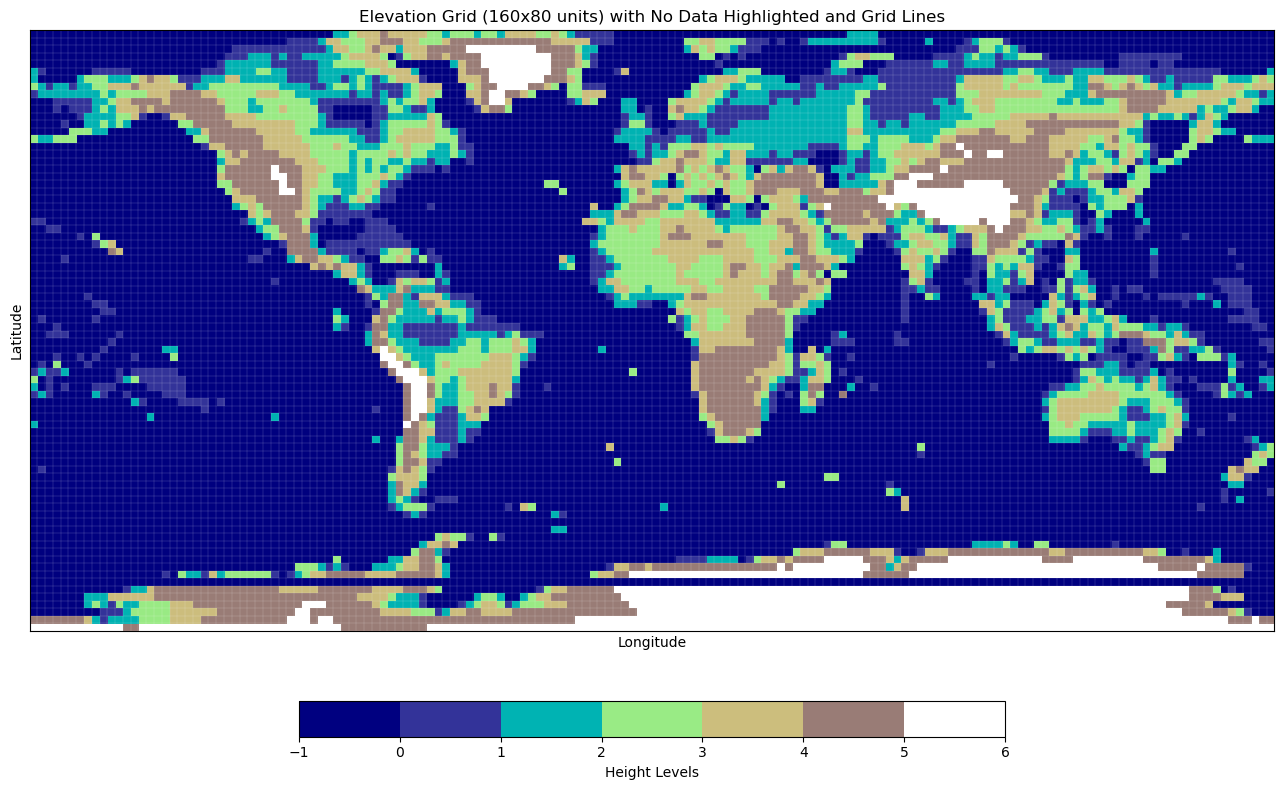

In [49]:
# Ensure all cells in height_grid are filled where they should have data
for _, row in gdf_land.iterrows():
    # Get grid cell bounds
    geom = row.geometry
    min_cell_x = int((geom.bounds[0] - minx) / cell_width)
    max_cell_x = int((geom.bounds[2] - minx) / cell_width)
    min_cell_y = int((geom.bounds[1] - miny) / cell_height)
    max_cell_y = int((geom.bounds[3] - miny) / cell_height)
    
    # Clip indices to grid dimensions
    min_cell_x = max(0, min_cell_x)
    max_cell_x = min(grid_width - 1, max_cell_x)
    min_cell_y = max(0, min_cell_y)
    max_cell_y = min(grid_height - 1, max_cell_y)
    
    # Fill cells that intersect the geometry
    for row_idx in range(min_cell_y, max_cell_y + 1):
        for col_idx in range(min_cell_x, max_cell_x + 1):
            # Skip if already filled
            if height_grid[row_idx, col_idx] != -1:
                continue
            # Assign the height level based on the geometry
            height_grid[row_idx, col_idx] = row.height_level

# Step 1: Define the grid dimensions and bounds
grid_width = 160
grid_height = 80

# Dataset bounds
minx, miny, maxx, maxy = gdf_land.total_bounds

# Compute the grid cell size
cell_width = (maxx - minx) / grid_width
cell_height = (maxy - miny) / grid_height

# Step 2: Create an empty grid for height levels
height_grid = np.full((grid_height, grid_width), -1)  # Fill with -1 for "no data"

# Step 3: Assign height levels to the grid
for _, row in gdf_land.iterrows():
    # Determine which grid cell the geometry falls into
    col = int((row.geometry.bounds[0] - minx) / cell_width)
    row_idx = int((row.geometry.bounds[1] - miny) / cell_height)
    
    # Ensure indices are within bounds
    col = min(max(col, 0), grid_width - 1)
    row_idx = min(max(row_idx, 0), grid_height - 1)
    
    # Assign the height level
    height_grid[row_idx, col] = row.height_level

# Step 4: Create a custom colormap
n_levels = 6  # Number of height levels
terrain_colors = plt.cm.terrain(np.linspace(0, 1, n_levels))  # Existing terrain colors
dark_blue = np.array([[0, 0, 0.5, 1]])  # RGBA for dark blue
all_colors = np.vstack((dark_blue, terrain_colors))  # Add dark blue as the first color
custom_cmap = mcolors.ListedColormap(all_colors)

# Normalize the data (account for -1 as "no data")
norm = mcolors.BoundaryNorm(boundaries=[-1, 0] + list(range(1, n_levels + 1)), ncolors=all_colors.shape[0])

# Step 5: Plot using imshow
fig, ax = plt.subplots(figsize=(16, 8))  # Aspect ratio matches 160x80
cax = ax.imshow(height_grid, cmap=custom_cmap, extent=[minx, maxx, miny, maxy], 
                origin='lower', norm=norm, interpolation='nearest')

# Add a colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Height Levels')

# Add grid lines
# Vertical lines
for x in np.arange(minx, maxx, cell_width):
    ax.axvline(x, color='white', linewidth=0.2, linestyle='-', alpha=0.5)

# Horizontal lines
for y in np.arange(miny, maxy, cell_height):
    ax.axhline(y, color='white', linewidth=0.2, linestyle='-', alpha=0.5)

# Hide tick labels
ax.set_xticks([])
ax.set_yticks([])

# Titles and axis adjustments
ax.set_title("Elevation Grid (160x80 units) with No Data Highlighted and Grid Lines")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
# plt.savefig("figures/elevation_grid_160x80_with_grid_lines.png", dpi=300, bbox_inches='tight')
plt.show()

Maybe we can try a different approach. I have a png image that is 80 pixels tall and 160 pixels wide. Could I reduce the size of the gdf_land so that it fits within that image bounds? Maybe using zonal statistics to reduce it down? I’m also thinking a different approach that says for every pixel in the image, take the corresponding gdf-land cell and apply that height color to that image in the photo to create a new image with colors from gdf_land’s height level column. Note: cells are missing that have no height data. Maybe I add rows in to have height level of 0 so that gdf_land_filled becomes a rectangle with every cell represented?

***

You can use a rasterization approach to reduce gdf_land to fit the bounds of an 80x160 image. The idea is to map the GeoDataFrame's polygons to a grid of pixels, where each pixel corresponds to a specific area in the spatial extent of gdf_land. Here's how you can proceed:

1. Fill Missing Cells
To ensure a rectangular grid, you can fill missing cells with height level 0. This step ensures every pixel in the image is represented.

2. Rasterization with Zonal Statistics
Use the rasterio and rasterstats libraries to:

Create a raster grid corresponding to the image size (80x160).
Map the gdf_land data to this grid using zonal statistics.
Assign a height level to each pixel based on the mean or dominant value.
3. Image Generation
After rasterizing the data:

Create an image where each pixel corresponds to a height level's color.
Use a colormap (e.g., terrain) to colorize the image.

Complete Code
```python
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from shapely.geometry import box

# Step 1: Fill missing cells in gdf_land
# Create a rectangular bounding box around gdf_land
xmin, ymin, xmax, ymax = gdf_land.total_bounds

# Define the resolution for the raster (80x160 image)
n_rows, n_cols = 80, 160
cell_width = (xmax - xmin) / n_cols
cell_height = (ymax - ymin) / n_rows

# Generate a full grid of polygons
grid_cells = [
    box(xmin + j * cell_width, ymin + i * cell_height,
        xmin + (j + 1) * cell_width, ymin + (i + 1) * cell_height)
    for i in range(n_rows) for j in range(n_cols)
]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf_land.crs)

# Join gdf_land to the grid, filling missing cells with height_level 0
gdf_land_filled = grid_gdf.sjoin(gdf_land[['height_level']], how='left').fillna({'height_level': 0})

# Step 2: Rasterize gdf_land_filled
# Map height levels to the raster grid
transform = from_bounds(xmin, ymin, xmax, ymax, n_cols, n_rows)
height_array = rasterize(
    [(geom, height) for geom, height in zip(gdf_land_filled.geometry, gdf_land_filled.height_level)],
    out_shape=(n_rows, n_cols),
    transform=transform,
    fill=0  # Default value for empty cells
)

# Step 3: Create the image
# Map height levels to colors using the terrain colormap
colors = plt.cm.terrain(np.linspace(0, 1, gdf_land['height_level'].max() + 1))
color_image = np.zeros((n_rows, n_cols, 3), dtype=np.uint8)

# Assign colors to each pixel
for level, color in enumerate(colors):
    color_image[height_array == level] = (color[:3] * 255).astype(np.uint8)

# Step 4: Display and save the image
plt.imshow(color_image, extent=(xmin, xmax, ymin, ymax))
plt.axis('off')
plt.savefig('gdf_land_rasterized.png', bbox_inches='tight')
plt.show()
```

Explanation of Key Steps
Fill Missing Cells
A full grid is created over the spatial extent of gdf_land.
Any cell not intersecting gdf_land gets a default height level of 0.
Rasterization
Each cell in the grid is mapped to a pixel in the 80x160 image.
The height_level value is assigned to each pixel using rasterize.
Image Creation
The terrain colormap maps height levels to colors.
The color_image array stores RGB values for each pixel, matching the height level.
Output
The final image is saved and displayed.
Notes
Speed: This approach is computationally efficient due to the rasterization step.
Missing Data: Unrepresented cells are filled with a default height level, ensuring completeness.
Flexibility: You can adjust the colormap, resolution, or statistic (e.g., mean, max) for custom visualizations.
This method generates an 80x160 pixel image with colors representing height levels from gdf_land.

In [29]:
print(gdf_land.shape)
gdf_land.head()

(5901, 3)


,geometry,elevation_mean,height_level
0,"POLYGON ((-177.75000 -90.00000, -177.75000 -87...",2995.587906,5
1,"POLYGON ((-177.75000 -87.82944, -177.75000 -85...",2879.981142,5
2,"POLYGON ((-177.75000 -85.65887, -177.75000 -83...",1891.065443,4
27,"POLYGON ((-177.75000 -31.39477, -177.75000 -29...",145.354839,1
31,"POLYGON ((-177.75000 -22.71251, -177.75000 -20...",25.785714,0


(12800, 2)
                                            geometry  elevation_mean
0  POLYGON ((-177.75000 -90.00000, -177.75000 -87...     2995.587906
1  POLYGON ((-177.75000 -87.82944, -177.75000 -85...     2879.981142
2  POLYGON ((-177.75000 -85.65887, -177.75000 -83...     1891.065443
3  POLYGON ((-177.75000 -83.48831, -177.75000 -81...             NaN
4  POLYGON ((-177.75000 -81.31774, -177.75000 -79...             NaN


<Axes: >

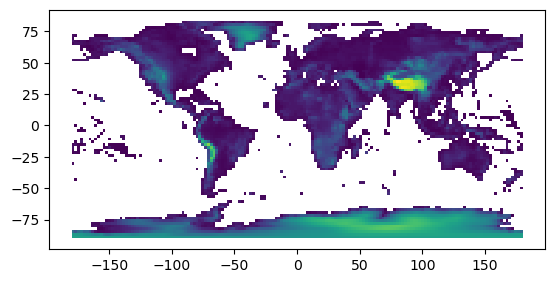

In [30]:
print(gdf_grid.shape)
print(gdf_grid.head())
gdf_grid.plot(column='elevation_mean')

In [32]:
# # Step 1: Fill missing cells in gdf_land
# # Create a rectangular bounding box around gdf_land
# xmin, ymin, xmax, ymax = gdf_land.total_bounds

# # Define the resolution for the raster (80x160 image)
# n_rows, n_cols = 80, 160
# cell_width = (xmax - xmin) / n_cols
# cell_height = (ymax - ymin) / n_rows

# # Generate a full grid of polygons
# grid_cells = [
#     box(xmin + j * cell_width, ymin + i * cell_height,
#         xmin + (j + 1) * cell_width, ymin + (i + 1) * cell_height)
#     for i in range(n_rows) for j in range(n_cols)
# ]
# grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf_land.crs)

# # Join gdf_land to the grid, filling missing cells with height_level 0
# gdf_land_filled = grid_gdf.sjoin(gdf_land[['height_level']], how='left').fillna({'height_level': 0})

# # Step 2: Rasterize gdf_land_filled
# # Map height levels to the raster grid
# transform = from_bounds(xmin, ymin, xmax, ymax, n_cols, n_rows)
# height_array = rasterize(
#     [(geom, height) for geom, height in zip(gdf_land_filled.geometry, gdf_land_filled.height_level)],
#     out_shape=(n_rows, n_cols),
#     transform=transform,
#     fill=0  # Default value for empty cells
# )

# # Step 3: Create the image
# # Map height levels to colors using the terrain colormap
# colors = plt.cm.terrain(np.linspace(0, 1, gdf_land['height_level'].max() + 1))
# color_image = np.zeros((n_rows, n_cols, 3), dtype=np.uint8)

# # Assign colors to each pixel
# for level, color in enumerate(colors):
#     color_image[height_array == level] = (color[:3] * 255).astype(np.uint8)

# # Step 4: Display and save the image
# plt.imshow(color_image, extent=(xmin, xmax, ymin, ymax))
# plt.axis('off')
# # plt.savefig('gdf_land_rasterized.png', bbox_inches='tight')
# plt.show()

In [33]:
# import geopandas as gpd
# from shapely.geometry import box
# import matplotlib.pyplot as plt
# from joblib import Parallel, delayed

# # Define the number of rows and columns for the grid
# n_rows, n_cols = 16, 16

# # Get the bounds of the gdf_land
# xmin, ymin, xmax, ymax = gdf_land.total_bounds

# # Calculate the width and height of each grid cell
# cell_width = (xmax - xmin) / n_cols
# cell_height = (ymax - ymin) / n_rows

# # Create a grid of bounding boxes for the patches
# grid_cells = [
#     box(xmin + j * cell_width, ymin + i * cell_height,
#         xmin + (j + 1) * cell_width, ymin + (i + 1) * cell_height)
#     for i in range(n_rows) for j in range(n_cols)
# ]

# # Assign each grid cell an index
# grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf_land.crs)

# # Create spatial index for gdf_land
# spatial_index = gdf_land.sindex

# # Create the figure and subplots with shared axes
# fig, axs = plt.subplots(
#     n_rows, n_cols, figsize=(20, 20),
#     constrained_layout=True, sharex=True, sharey=True
# )

# # Define a function to process each grid cell
# def process_cell(cell, idx):
#     row, col = divmod(idx, n_cols)
#     ax = axs[row, col]
    
#     # Efficiently find polygons within the cell using the spatial index
#     possible_matches_index = list(spatial_index.intersection(cell.bounds))
#     cell_gdf_land = gdf_land.iloc[possible_matches_index]
#     cell_gdf_land = cell_gdf_land[cell_gdf_land.intersects(cell)]
    
#     if not cell_gdf_land.empty:
#         # Plot the clipped GeoDataFrame
#         cell_gdf_land.plot(ax=ax, column='height_level', cmap=cmap, edgecolor='white', alpha=0.8)
#         # Plot the grid cell boundary
#         gpd.GeoSeries([cell]).boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    
#     # Turn off axis for the subplot
#     ax.axis('off')

# # Parallelize the process across all cells
# Parallel(n_jobs=-1)(delayed(process_cell)(cell, idx) for idx, cell in enumerate(grid_cells))

# # Show the final plot
# plt.show()

We will adjust the above code to produce a pure plot of the elevation data with grid.

In [34]:
# # Number of levels
# n_levels = 6  # User-defined number of levels

# # Step 1: Filter out ocean floors or very low elevations
# threshold = 1  # 1 meter cutoff for land surface
# gdf_land = gdf_grid[gdf_grid['elevation_mean'] >= threshold].copy()

# # Step 2: Quantile binning to redistribute elevation data evenly across levels
# gdf_land['height_level'] = pd.qcut(
#     gdf_land['elevation_mean'],
#     q=n_levels,
#     labels=range(n_levels)
# )

# # Convert height levels to integers for better readability
# gdf_land['height_level'] = gdf_land['height_level'].astype(int)

# # Define custom colors for the levels using the terrain colormap
# colors = plt.cm.terrain(np.linspace(0, 1, n_levels))
# cmap = mcolors.ListedColormap(colors)

# # Step 3: Visualization setup
# fig, ax_main = plt.subplots(figsize=(12, 10))

# # Base grid with grey edges
# gdf_land.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# # Plot the grid colored by height levels
# gdf_land.plot(
#     ax=ax_main,
#     column='height_level',
#     edgecolor='w',
#     cmap=cmap,
#     alpha=0.95
# )

# # Remove axis and title
# ax_main.axis('off')

# # Tight layout to remove padding
# plt.tight_layout()

# # Save the plot only (no title, borders, or other elements)
# elevation_path = 'figures/elevation_only'
# plt.savefig(elevation_path + '.pdf', bbox_inches='tight', pad_inches=0)
# plt.savefig(elevation_path + '.png', bbox_inches='tight', pad_inches=0)
# plt.savefig(elevation_path + '.jpg', bbox_inches='tight', pad_inches=0, dpi=300)

# plt.show()

In [35]:
# from PIL import Image

# def resize_image_pil(image, target_height, target_width, resample=Image.BICUBIC):
#     """
#     Resize the input image to specified dimensions using PIL.Image.resize.

#     Parameters:
#     - image (PIL.Image.Image): Input image to be resized.
#     - target_height (int): Desired height in pixels.
#     - target_width (int): Desired width in pixels.
#     - resample: Resampling filter (default: Image.NEAREST for minimal color blending).

#     Returns:
#     - PIL.Image.Image: Resized image as a PIL Image object.
#     """
#     # Resize the image
#     resized_image = image.resize((target_width, target_height), resample=resample)
#     return resized_image

# # Parameters
# target_height = 80 # Height in pixels
# target_width = 160 # Width in pixels

# # Open the saved quantized image
# quantized_image = Image.open(elevation_path + '.png').convert("RGB")

# # debugging
# original_width, original_height = quantized_image.size
# aspect_ratio = original_width / original_height
# print(aspect_ratio)
# target_aspect_ratio = target_width / target_height

# if abs(aspect_ratio - target_aspect_ratio) > 1e-6:
#     print("Aspect ratio mismatch! Consider cropping or padding the image.")
# # # # #

# # Downsample using PIL.Image.resize
# resized_image = resize_image_pil(quantized_image, target_height, target_width)

# # enhance the brightness
# brightness_factor = 1.75
# enhancer = ImageEnhance.Brightness(image)
# brightened_image = enhancer.enhance(brightness_factor)

# # Save the resized image
# image_path = f'figures/bluemarble_resized_pil_h{target_height}_w{target_width}.png'
# resized_image.save(image_path)

# # Display the resized image
# # resized_image.show()

# # Load the resized image
# resized_image = Image.open(image_path)

# # Convert the image to a numpy array
# img_array = np.array(resized_image)

# # Get the dimensions of the image
# height, width, _ = img_array.shape

# # Create a figure with a grid
# fig, ax = plt.subplots(figsize=(12, 8))

# # Plot the image
# ax.imshow(img_array)

# # Add a grid overlay
# for y in range(height):
#     ax.axhline(y - 0.5, color='grey', linewidth=0.5)  # Horizontal lines
# for x in range(width):
#     ax.axvline(x - 0.5, color='grey', linewidth=0.5)  # Vertical lines

# # Hide axes for better visualization
# ax.axis('off')

# # Add a title
# ax.set_title(f'Resized Image with {width}x{height} Grid', fontsize=16)

# # Save and display the plot
# # plt.savefig(image_path, bbox_inches='tight')
# plt.show()

In [36]:
# # Step 2: Load the saved plot image
# saved_image = Image.open('figures/bluemarble_resized_pil_h80_w160.png')
# # saved_image = Image.open(elevation_path + '.png')
# image_array = np.array(saved_image)

# # Step 3: Define patch parameters
# patch_height = 16
# patch_width = 16

# # Calculate the number of patches along each dimension
# n_patches_y = image_array.shape[0] // patch_height
# n_patches_x = image_array.shape[1] // patch_width
# total_patches = n_patches_x * n_patches_y

# # Step 4: Create the figure for visualization
# fig, axs = plt.subplots(n_patches_y, n_patches_x, figsize=(12, 12))
# plt.subplots_adjust(wspace=0.2, hspace=0.05)

# # Step 5: Extract and plot each patch
# patch_number = 1
# for i in range(n_patches_y):
#     for j in range(n_patches_x):
#         # Slice the patch
#         patch = image_array[
#             i * patch_height: (i + 1) * patch_height,
#             j * patch_width: (j + 1) * patch_width,
#         ]
#         # Plot the patch
#         ax = axs[i, j]
#         ax.imshow(patch)

#         # Add vertical and horizontal grid lines
#         ax.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
#         ax.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
#         ax.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
#         ax.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border

#        # Add local tick labels (0 to 15)
#         ax.set_xticks(np.arange(0, patch_width, 1))
#         ax.set_yticks(np.arange(0, patch_height, 1))
#         ax.set_xticklabels(range(patch_width))
#         ax.set_yticklabels(range(patch_height))

#         # Optional: Internal grid lines
#         for y in range(1, patch_height):
#             ax.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
#         for x in range(1, patch_width):
#             ax.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

#        # Adjust tick label spacing
#         ax.tick_params(axis='x', labelsize=2.5, pad=0.5)  # Reduce horizontal tick label distance
#         ax.tick_params(axis='y', labelsize=2.5, pad=0.5)  # Reduce vertical tick label distance

#         # add large number denoting patch position
#         ax.text(x=0.5, y=0.5, 
#                 s=str(patch_number), c='grey', alpha=0.65, 
#                 transform=ax.transAxes, fontsize = 24, 
#                 ha='center', va='center')

#         patch_number += 1

# # Step 6: Add a title and save the overview
# total_width = patch_width * n_patches_x
# total_height = patch_height * n_patches_y

# plt.suptitle(t=f'Overview of Elevation Patches, {total_width}x{total_height}', y=0.875)
# plt.savefig('figures/elevation_patches_overview.png', bbox_inches='tight')
# plt.savefig('figures/elevation_patches_overview.pdf', bbox_inches='tight')
# plt.show()

In [37]:
# # Parameters for patches
# patch_height = 16
# patch_width = 16

# # Convert the resized image to a NumPy array
# image_path = 
# image_array = np.array(image_path)

# # Calculate the number of patches along each dimension
# n_patches_y = image_array.shape[0] // patch_height
# n_patches_x = image_array.shape[1] // patch_width
# total_patches = n_patches_x * n_patches_y

# # Create the figure for visualization
# fig, axs = plt.subplots(n_patches_y, n_patches_x, figsize=(12, 12))
# plt.subplots_adjust(wspace=0.2, hspace=0.05)  # Adjust space for better visualization

# # Extract and plot each patch
# patch_number = 1
# for i in range(n_patches_y):
#     for j in range(n_patches_x):
#         # Slice the patch
#         patch = image_array[
#             i * patch_height: (i + 1) * patch_height,
#             j * patch_width: (j + 1) * patch_width,
#         ]
#         # Plot the patch
#         ax = axs[i, j]
#         ax.imshow(patch)

#         # Add vertical and horizontal lines to act as grid lines
#         ax.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
#         ax.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
#         ax.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
#         ax.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
        
#         # Optional: Add lines between patches (only if necessary)
#         for y in range(1, patch_height):
#             ax.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Horizontal lines
#         for x in range(1, patch_width):
#             ax.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Vertical lines

#         # Add local tick labels (0 to 15)
#         ax.set_xticks(np.arange(0, patch_width, 1))
#         ax.set_yticks(np.arange(0, patch_height, 1))
#         ax.set_xticklabels(range(patch_width))
#         ax.set_yticklabels(range(patch_height))

#         # Adjust tick label spacing
#         ax.tick_params(axis='x', labelsize=2.5, pad=0.5)  # Reduce horizontal tick label distance
#         ax.tick_params(axis='y', labelsize=2.5, pad=0.5)  # Reduce vertical tick label distance

#         # add large number denoting patch position
#         ax.text(x=0.5, y=0.5, 
#                 s=str(patch_number), c='grey', alpha=0.65, 
#                 transform=ax.transAxes, fontsize = 24, 
#                 ha='center', va='center')

#         patch_number += 1

# # Calculate total dimensions of the patch assembly
# total_width = patch_width * n_patches_x
# total_height = patch_height * n_patches_y

# # Add a title
# plt.suptitle(t=f'Overview of Patches, {total_width}x{total_height}', y=0.875)

# # Save the figure in different formats
# plt.savefig('figures/patches/overview.pdf', bbox_inches='tight')
# plt.savefig('figures/patches/overview.png', bbox_inches='tight')
# plt.savefig('figures/patches/overview.jpg', bbox_inches='tight')

# # Show the figure
# plt.show()

In [38]:
# # Create a directory to save individual patches
# output_dir = 'figures/patches'
# os.makedirs(output_dir, exist_ok=True)

# patch_number = 1
# for i in range(n_patches_y):
#     for j in range(n_patches_x):
#         # Slice the patch
#         patch = image_array[
#             i * patch_height: (i + 1) * patch_height,
#             j * patch_width: (j + 1) * patch_width,
#         ]

#         # Count unique colors in the patch
#         unique_colors, counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
#         hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

#         # Create a figure with gridspec for patch and swatches
#         fig = plt.figure(figsize=(6, 6))
#         gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)

#         # Plot the patch
#         ax_patch = fig.add_subplot(gs[0, 0])
#         ax_patch.imshow(patch)
#         ax_patch.set_title(f'Patch {patch_number}', fontsize=16)
#         # ax_patch.axis('off')

#         # Add tick labels
#         ax_patch.set_xticks(np.arange(0, patch_width, 1))
#         ax_patch.set_yticks(np.arange(0, patch_height, 1))
#         ax_patch.set_xticklabels(range(patch_width))
#         ax_patch.set_yticklabels(range(patch_height))

#         # Adjust tick label spacing
#         ax_patch.tick_params(axis='x', labelsize=5, pad=2)  # Adjust for visibility
#         ax_patch.tick_params(axis='y', labelsize=5, pad=2)

#         # Add gridlines and labels
#         ax_patch.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
#         ax_patch.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
#         ax_patch.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
#         ax_patch.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
#         for y in range(1, patch_height):
#             ax_patch.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
#         for x in range(1, patch_width):
#             ax_patch.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

#         # Create swatches with color counts
#         gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors), subplot_spec=gs[1, 0], wspace=0.3)
#         for idx, (color, hex_color, count) in enumerate(zip(unique_colors, hex_colors, counts)):
#             ax_swatch = fig.add_subplot(gs_swatch[0, idx])
#             ax_swatch.imshow([[color / 255]])  # Normalize RGB values
#             ax_swatch.axis('off')
#             ax_swatch.set_title(f"{hex_color}\n{count} px", fontsize=8, pad=5)

#         # Save the figure in multiple formats
#         patch_file_base = f'{output_dir}/patch_{patch_number:03d}'
#         plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
#         plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
#         plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

#         # Close the figure to save memory
#         plt.close(fig)

#         patch_number += 1

# print(f"All patches with swatches saved to {output_dir}")


In [39]:
# img = mpimg.imread('figures/patches/patch_001.jpg')
# imgplot = plt.imshow(img)
# plt.axis('off')
# plt.show()

### 8 levels

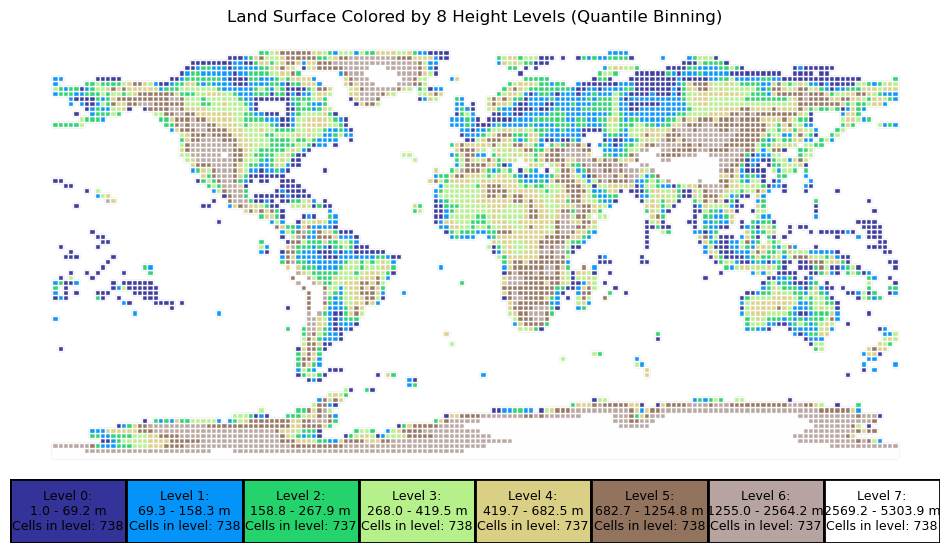

In [40]:
# Number of levels
n_levels = 8  # User-defined number of levels

# Step 1: Filter out ocean floors or very low elevations
threshold = 1  # 1 meter cutoff for land surface
gdf_land = gdf_grid[gdf_grid['elevation_mean'] >= threshold].copy()

# Step 2: Quantile binning to redistribute elevation data evenly across levels
gdf_land['height_level'] = pd.qcut(
    gdf_land['elevation_mean'],
    q=n_levels,
    labels=range(n_levels)
)

# Convert height levels to integers for better readability
gdf_land['height_level'] = gdf_land['height_level'].astype(int)

# Define custom colors for the levels using the terrain colormap
colors = plt.cm.terrain(np.linspace(0, 1, n_levels))
cmap = mcolors.ListedColormap(colors)

# Step 3: Visualization setup using GridSpec
fig = plt.figure(figsize=(12, 10))  # Adjust overall figure size
gs = fig.add_gridspec(2, 1, height_ratios=[15, 1])  # Tighten second row

# --- Main Plot ---
ax_main = fig.add_subplot(gs[0])

# Base grid with grey edges
gdf_land.plot(ax=ax_main, color='w', edgecolor='grey', alpha=0.5)

# Plot the grid colored by height levels
gdf_land.plot(
    ax=ax_main,
    column='height_level',
    edgecolor='w',
    cmap=cmap,
    alpha=0.95
)

ax_main.axis('off')
ax_main.set_title(f"Land Surface Colored by {n_levels} Height Levels (Quantile Binning)")

# --- Custom Color Bar Subplot ---
ax_cbar = fig.add_subplot(gs[1])

# Reduce spacing between plots
fig.subplots_adjust(hspace=-0.5)  # Adjust spacing between GridSpec rows

# Add color swatches for each level
for i in range(n_levels):
    # Get the elevation range for the current level
    level_min = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].min()
    level_max = gdf_land[gdf_land['height_level'] == i]['elevation_mean'].max()

    # Add a colored rectangle for each level with a black border
    ax_cbar.add_patch(
        plt.Rectangle(
            (i / n_levels, 0),  # position: (x, y) and width
            1 / n_levels,  # width of each swatch
            1,  # height of each swatch
            facecolor=colors[i],  # Fill color (facecolor)
            linewidth=2,  # Black border width
            edgecolor='black'  # Border color
        )
    )

    # Set title with level and its corresponding elevation range
    level_counts = gdf_land['height_level'].value_counts().sort_index()
    ax_cbar.text(
        (i + 0.5) / n_levels,  # X position for the text (centered)
        0.5,  # Y position for the text (vertically centered)
        f"Level {i}:\n{level_min:.1f} - {level_max:.1f} m\nCells in level: {level_counts[i]}",  # Text content
        ha='center', va='center', color='black', fontsize=9
    )

ax_cbar.set_xlim(0, 1)
ax_cbar.set_ylim(0, 1)
ax_cbar.axis('off')  # Hide the axis

plt.savefig(f'figures/elevation_with_{n_levels}.pdf', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}.jpg', bbox_inches='tight')
plt.savefig(f'figures/elevation_with_{n_levels}.png', bbox_inches='tight')

plt.show()

#### Save patches for building

In [42]:
# # Parameters for patches
# patch_height = 16
# patch_width = 16

# # Convert the resized image to a NumPy array
# image_array = np.array(resized_image)

# # Calculate the number of patches along each dimension
# n_patches_y = image_array.shape[0] // patch_height
# n_patches_x = image_array.shape[1] // patch_width
# total_patches = n_patches_x * n_patches_y

# # Create the figure for visualization
# fig, axs = plt.subplots(n_patches_y, n_patches_x, figsize=(12, 12))
# plt.subplots_adjust(wspace=0.2, hspace=0.05)  # Adjust space for better visualization

# # Extract and plot each patch
# patch_number = 1
# for i in range(n_patches_y):
#     for j in range(n_patches_x):
#         # Slice the patch
#         patch = image_array[
#             i * patch_height: (i + 1) * patch_height,
#             j * patch_width: (j + 1) * patch_width,
#         ]
#         # Plot the patch
#         ax = axs[i, j]
#         ax.imshow(patch)

#         # Add vertical and horizontal lines to act as grid lines
#         ax.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
#         ax.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
#         ax.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
#         ax.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
        
#         # Optional: Add lines between patches (only if necessary)
#         for y in range(1, patch_height):
#             ax.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Horizontal lines
#         for x in range(1, patch_width):
#             ax.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Vertical lines

#         # Add local tick labels (0 to 15)
#         ax.set_xticks(np.arange(0, patch_width, 1))
#         ax.set_yticks(np.arange(0, patch_height, 1))
#         ax.set_xticklabels(range(patch_width))
#         ax.set_yticklabels(range(patch_height))

#         # Adjust tick label spacing
#         ax.tick_params(axis='x', labelsize=2.5, pad=0.5)  # Reduce horizontal tick label distance
#         ax.tick_params(axis='y', labelsize=2.5, pad=0.5)  # Reduce vertical tick label distance

#         # add large number denoting patch position
#         ax.text(x=0.5, y=0.5, 
#                 s=str(patch_number), c='grey', alpha=0.65, 
#                 transform=ax.transAxes, fontsize = 24, 
#                 ha='center', va='center')

#         patch_number += 1

# # Calculate total dimensions of the patch assembly
# total_width = patch_width * n_patches_x
# total_height = patch_height * n_patches_y

# # Add a title
# plt.suptitle(t=f'Overview of Patches, {total_width}x{total_height}', y=0.875)

# # Save the figure in different formats
# plt.savefig('figures/patches/overview.pdf', bbox_inches='tight')
# plt.savefig('figures/patches/overview.png', bbox_inches='tight')
# plt.savefig('figures/patches/overview.jpg', bbox_inches='tight')

# # Show the figure
# plt.show()

In [43]:
# # Create a directory to save individual patches
# output_dir = 'figures/patches'
# os.makedirs(output_dir, exist_ok=True)

# patch_number = 1
# for i in range(n_patches_y):
#     for j in range(n_patches_x):
#         # Slice the patch
#         patch = image_array[
#             i * patch_height: (i + 1) * patch_height,
#             j * patch_width: (j + 1) * patch_width,
#         ]

#         # Count unique colors in the patch
#         unique_colors, counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
#         hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

#         # Create a figure with gridspec for patch and swatches
#         fig = plt.figure(figsize=(6, 6))
#         gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)

#         # Plot the patch
#         ax_patch = fig.add_subplot(gs[0, 0])
#         ax_patch.imshow(patch)
#         ax_patch.set_title(f'Patch {patch_number}', fontsize=16)
#         # ax_patch.axis('off')

#         # Add tick labels
#         ax_patch.set_xticks(np.arange(0, patch_width, 1))
#         ax_patch.set_yticks(np.arange(0, patch_height, 1))
#         ax_patch.set_xticklabels(range(patch_width))
#         ax_patch.set_yticklabels(range(patch_height))

#         # Adjust tick label spacing
#         ax_patch.tick_params(axis='x', labelsize=5, pad=2)  # Adjust for visibility
#         ax_patch.tick_params(axis='y', labelsize=5, pad=2)

#         # Add gridlines and labels
#         ax_patch.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
#         ax_patch.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
#         ax_patch.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
#         ax_patch.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
#         for y in range(1, patch_height):
#             ax_patch.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
#         for x in range(1, patch_width):
#             ax_patch.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

#         # Create swatches with color counts
#         gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors), subplot_spec=gs[1, 0], wspace=0.3)
#         for idx, (color, hex_color, count) in enumerate(zip(unique_colors, hex_colors, counts)):
#             ax_swatch = fig.add_subplot(gs_swatch[0, idx])
#             ax_swatch.imshow([[color / 255]])  # Normalize RGB values
#             ax_swatch.axis('off')
#             ax_swatch.set_title(f"{hex_color}\n{count} px", fontsize=8, pad=5)

#         # Save the figure in multiple formats
#         patch_file_base = f'{output_dir}/patch_{patch_number:03d}'
#         plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
#         plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
#         plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

#         # Close the figure to save memory
#         plt.close(fig)

#         patch_number += 1

# print(f"All patches with swatches saved to {output_dir}")


In [44]:
# img = mpimg.imread('figures/patches/patch_001.jpg')
# imgplot = plt.imshow(img)
# plt.axis('off')
# plt.show()

## Add surface color

We will attempt to downsample the colors of the bare earth surface to add to our lego map.

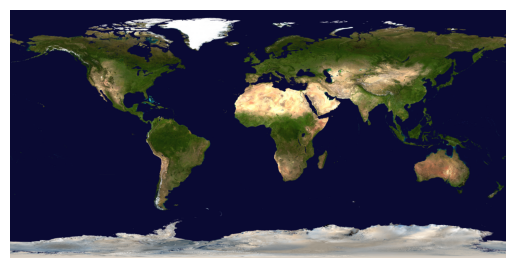

In [45]:
# https://svs.gsfc.nasa.gov/vis/a000000/a002900/a002915/bluemarble-2048.png
# thankfully this is in the same projection as our other assets
img = mpimg.imread('figures/bluemarble-2048.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

First, let's count the number of colors that the above image has.

In [46]:
# load the image and convert to RGB mode
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# convert image to a numpy array
image_array = np.array(image)

# reshape the array into a list of RGB values
pixels = image_array.reshape(-1, 3)

# count unique colors
unique_colors = np.unique(pixels, axis=0)
print(f"Number of unique colors: {len(unique_colors)}")

Number of unique colors: 220909


That's quite a large number of colors. We'll use the Median Cut algorithm to cluster the colors into a much smaller number. Let's see what a much reduced amount (≤15) gives us.

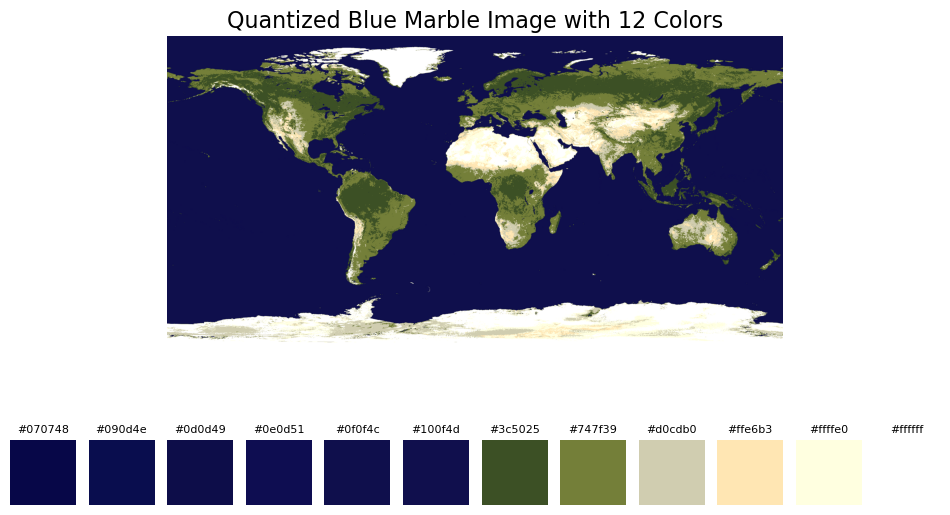

In [47]:
n_colors = 12
brightness_factor = 1.5  # factor to increase brightness

# load the image and convert to RGB
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# enhance the brightness
enhancer = ImageEnhance.Brightness(image)
brightened_image = enhancer.enhance(brightness_factor)

# apply quantization with Median Cut
quantized_image = brightened_image.quantize(method=Image.MEDIANCUT, colors=n_colors).convert('RGB')

# save the quantized image
saved_img_path = f'figures/bluemarble-2048_downsampled_with_{n_colors}_colors.png'
quantized_image.save(saved_img_path)

# get the unique colors from the quantized image
unique_colors = np.unique(np.array(quantized_image).reshape(-1, 3), axis=0)

# convert RGB to HEX
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# create the figure and grid layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.5)

# main plot: quantized image
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(quantized_image)
ax_main.axis('off')
ax_main.set_title(f'Quantized Blue Marble Image with {n_colors} Colors', fontsize=16)

# subplots: color swatches
gs_swatch = GridSpecFromSubplotSpec(1, n_colors, subplot_spec=gs[1, 0], wspace=0.2)
for i, (color, hex_color) in enumerate(zip(unique_colors, hex_colors)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')
    ax_swatch.set_title(hex_color, fontsize=8, pad=5)

# save the plot
plt.savefig(f'figures/bluemarble-2048_downsampled_{n_colors}_example.png', bbox_inches='tight')

plt.show()

### Discretize surface color

In [48]:
saved_img_path = f'figures/bluemarble-2048_downsampled_with_12_colors.png'

This shows the world surface color with what the Lego set's dimensions are:

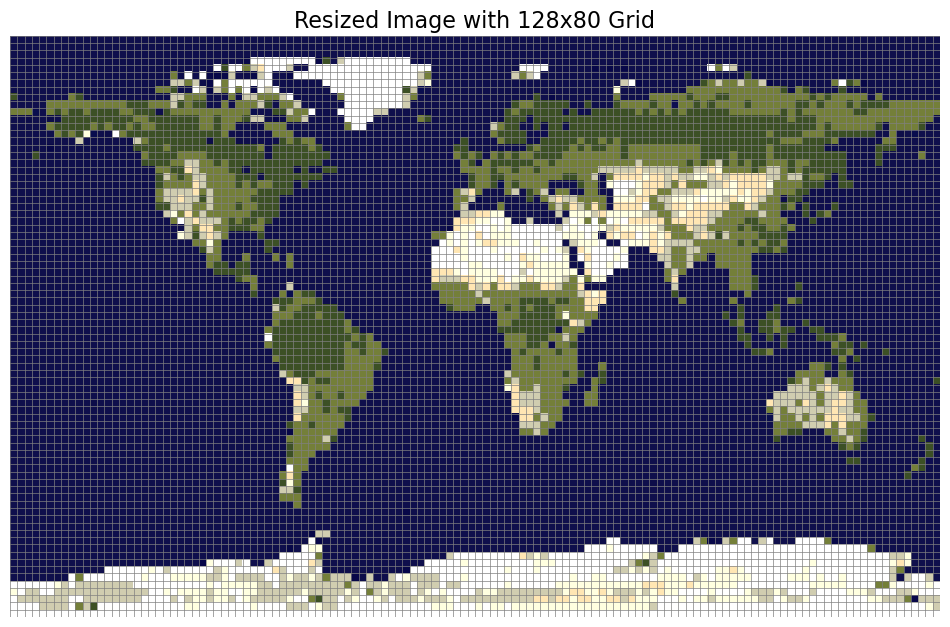

In [49]:
from PIL import Image

def resize_image_pil(image, target_height, target_width, resample=Image.NEAREST):
    """
    Resize the input image to specified dimensions using PIL.Image.resize.

    Parameters:
    - image (PIL.Image.Image): Input image to be resized.
    - target_height (int): Desired height in pixels.
    - target_width (int): Desired width in pixels.
    - resample: Resampling filter (default: Image.NEAREST for minimal color blending).

    Returns:
    - PIL.Image.Image: Resized image as a PIL Image object.
    """
    # Resize the image
    resized_image = image.resize((target_width, target_height), resample=resample)
    return resized_image

# Parameters
target_height = 80 # Height in pixels
target_width = 128 # Width in pixels

# Open the saved quantized image
quantized_image = Image.open(saved_img_path).convert("RGB")

# Downsample using PIL.Image.resize
resized_image = resize_image_pil(quantized_image, target_height, target_width)

# Save the resized image
image_path = f'figures/bluemarble_resized_pil_h{target_height}_w{target_width}.png'
resized_image.save(image_path)

# Display the resized image
# resized_image.show()

# Load the resized image
resized_image = Image.open(image_path)

# Convert the image to a numpy array
img_array = np.array(resized_image)

# Get the dimensions of the image
height, width, _ = img_array.shape

# Create a figure with a grid
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the image
ax.imshow(img_array)

# Add a grid overlay
for y in range(height):
    ax.axhline(y - 0.5, color='grey', linewidth=0.5)  # Horizontal lines
for x in range(width):
    ax.axvline(x - 0.5, color='grey', linewidth=0.5)  # Vertical lines

# Hide axes for better visualization
ax.axis('off')

# Add a title
ax.set_title(f'Resized Image with {width}x{height} Grid', fontsize=16)

# Save and display the plot
plt.savefig(image_path, bbox_inches='tight')
plt.show()

The above projection is faithful to the Lego set, but it looks like the equatorial regions are stretched. What about a true 2:1 aspect ratio, per the ratio on the original "Blue Marble" image?

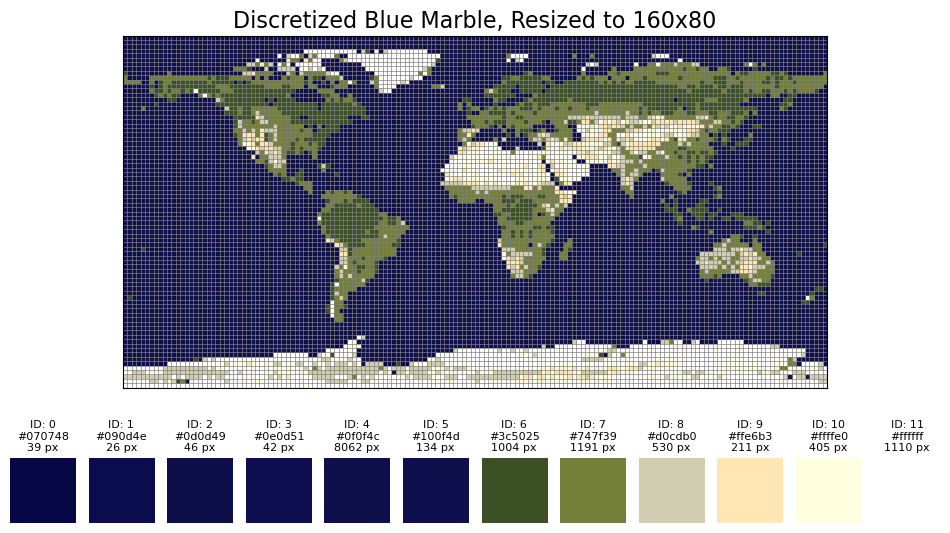

In [66]:
def resize_image_pil(image, target_height, target_width, resample=Image.NEAREST):
    """
    Resize the input image to specified dimensions using PIL.Image.resize.

    Parameters:
    - image (PIL.Image.Image): Input image to be resized.
    - target_height (int): Desired height in pixels.
    - target_width (int): Desired width in pixels.
    - resample: Resampling filter (default: Image.NEAREST for minimal color blending).

    Returns:
    - PIL.Image.Image: Resized image as a PIL Image object.
    """
    # Resize the image
    resized_image = image.resize((target_width, target_height), resample=resample)
    return resized_image

# Parameters
target_height = 80  # Example height in pixels
target_width = 160   # Example width in pixels

# Load the quantized image
quantized_image = Image.open('figures/bluemarble-2048_downsampled_with_12_colors.png').convert("RGB")

# Downsample the quantized image using PIL.Image.resize
resized_image = resize_image_pil(quantized_image, target_height, target_width)

# Save the resized image
image_path = f'figures/bluemarble_{target_width}x{target_height}'
image_path_with_ext = image_path + '.png'
resized_image.save(image_path_with_ext)

# Convert the resized image to a NumPy array
resized_array = np.array(resized_image)

# Count the number of pixels for each unique color
unique_colors_surface, counts = np.unique(resized_array.reshape(-1, 3), axis=0, return_counts=True)

# Convert RGB colors to HEX for visualization
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# Display results
# for color, count in zip(hex_colors, counts):
    # print(f"Color {color}: {count} pixels")

# Visualization: Resized Image and Color Swatches with Counts
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.25)

# --- Main Plot: Resized Image ---
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(resized_image)
# ax_main.axis('off')
ax_main.set_title(f'Discretized Blue Marble, Resized to {target_width}x{target_height}', fontsize=16)

# --- Subplots: Color Swatches with Pixel Counts ---
gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors), subplot_spec=gs[1, 0], wspace=0.2)
for i, (color, hex_color, count) in enumerate(zip(unique_colors, hex_colors, counts)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')
    ax_swatch.set_title(f"ID: {i}\n{hex_color}\n{count} px", fontsize=8, pad=5)

# Add a grid overlay
# for y in range(height):
#     ax_main.axhline(y - 0.5, color='grey', linewidth=0.5)  # Horizontal lines
# for x in range(width):
#     ax_main.axvline(x - 0.5, color='grey', linewidth=0.5)  # Vertical lines
ax_main.set_xticks(np.arange(-0.5, target_width, 1), minor=True)  # Vertical grid lines
ax_main.set_yticks(np.arange(-0.5, target_height, 1), minor=True)  # Horizontal grid lines
ax_main.grid(which="minor", color="grey", linestyle="-", linewidth=0.5)  # Grid styling
ax_main.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)  # Hide minor ticks

plt.savefig(image_path + '_overview.png', bbox_inches='tight')
plt.savefig(image_path + '_overview.pdf', bbox_inches='tight')
plt.savefig(image_path + '_overview.jpg', bbox_inches='tight')

plt.show()

In [67]:
unique_colors_surface

array([[  7,   7,  72],
       [  9,  13,  78],
       [ 13,  13,  73],
       [ 14,  13,  81],
       [ 15,  15,  76],
       [ 16,  15,  77],
       [ 60,  80,  37],
       [116, 127,  57],
       [208, 205, 176],
       [255, 230, 179],
       [255, 255, 224],
       [255, 255, 255]], dtype=uint8)

That looks much better! To make a builder-friendly version of the main image above, we'll make patches to make it easier to follow along and build.

### Save patches for building

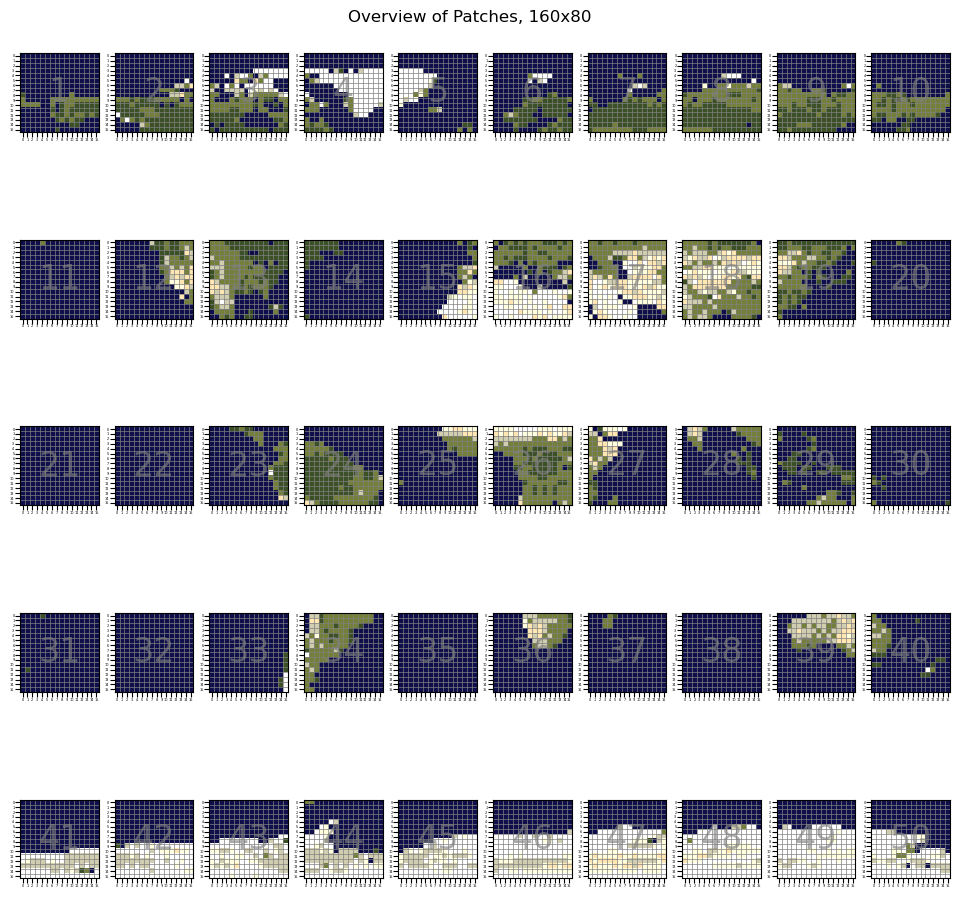

In [68]:
# Parameters for patches
patch_height = 16
patch_width = 16

# Convert the resized image to a NumPy array
image_array = np.array(resized_image)

# Calculate the number of patches along each dimension
n_patches_y = image_array.shape[0] // patch_height
n_patches_x = image_array.shape[1] // patch_width
total_patches = n_patches_x * n_patches_y

# Create the figure for visualization
fig, axs = plt.subplots(n_patches_y, n_patches_x, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.05)  # Adjust space for better visualization

# Extract and plot each patch
patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = image_array[
            i * patch_height: (i + 1) * patch_height,
            j * patch_width: (j + 1) * patch_width,
        ]
        # Plot the patch
        ax = axs[i, j]
        ax.imshow(patch)

        # Add vertical and horizontal lines to act as grid lines
        ax.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
        ax.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
        ax.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
        ax.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
        
        # Optional: Add lines between patches (only if necessary)
        for y in range(1, patch_height):
            ax.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Horizontal lines
        for x in range(1, patch_width):
            ax.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Vertical lines

        # Add local tick labels (0 to 15)
        ax.set_xticks(np.arange(0, patch_width, 1))
        ax.set_yticks(np.arange(0, patch_height, 1))
        ax.set_xticklabels(range(patch_width))
        ax.set_yticklabels(range(patch_height))

        # Adjust tick label spacing
        ax.tick_params(axis='x', labelsize=2.5, pad=0.5)  # Reduce horizontal tick label distance
        ax.tick_params(axis='y', labelsize=2.5, pad=0.5)  # Reduce vertical tick label distance

        # add large number denoting patch position
        ax.text(x=0.5, y=0.5, 
                s=str(patch_number), c='grey', alpha=0.65, 
                transform=ax.transAxes, fontsize = 24, 
                ha='center', va='center')

        patch_number += 1

# Calculate total dimensions of the patch assembly
total_width = patch_width * n_patches_x
total_height = patch_height * n_patches_y

# Add a title
plt.suptitle(t=f'Overview of Patches, {total_width}x{total_height}', y=0.875)

# Save the figure in different formats
plt.savefig('figures/patches/overview.pdf', bbox_inches='tight')
plt.savefig('figures/patches/overview.png', bbox_inches='tight')
plt.savefig('figures/patches/overview.jpg', bbox_inches='tight')

# Show the figure
plt.show()

Perfect. Now I will save each individual patch as its own file for ease of use in buliding the map.

In [86]:
# access unique color list object
color_to_id = {tuple(color): idx for idx, color in enumerate(unique_colors_surface)}

# Create a directory to save individual patches
output_dir = 'figures/patches'
os.makedirs(output_dir, exist_ok=True)

patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = image_array[
            i * patch_height: (i + 1) * patch_height,
            j * patch_width: (j + 1) * patch_width,
        ]

        # Count unique colors in the patch
        unique_colors, counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
        hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

        # Create a figure with gridspec for patch and swatches
        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)

        # Plot the patch
        ax_patch = fig.add_subplot(gs[0, 0])
        ax_patch.imshow(patch)
        ax_patch.set_title(f'Patch {patch_number}', fontsize=16)
        # ax_patch.axis('off')

        # Add tick labels
        ax_patch.set_xticks(np.arange(0, patch_width, 1))
        ax_patch.set_yticks(np.arange(0, patch_height, 1))
        ax_patch.set_xticklabels(range(patch_width))
        ax_patch.set_yticklabels(range(patch_height))

        # Adjust tick label spacing
        ax_patch.tick_params(axis='x', labelsize=5, pad=2)  # Adjust for visibility
        ax_patch.tick_params(axis='y', labelsize=5, pad=2)

        # Add gridlines and labels
        ax_patch.axvline(x=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Left border
        ax_patch.axvline(x=patch_width - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Right border
        ax_patch.axhline(y=-0.5, color='grey', linestyle='-', linewidth=0.5)  # Bottom border
        ax_patch.axhline(y=patch_height - 0.5, color='grey', linestyle='-', linewidth=0.5)  # Top border
        for y in range(1, patch_height):
            ax_patch.axhline(y=y - 0.5, color='grey', linestyle='-', linewidth=0.5)
        for x in range(1, patch_width):
            ax_patch.axvline(x=x - 0.5, color='grey', linestyle='-', linewidth=0.5)

        # Overlay IDs on cells with outlined text
        for y in range(patch_height):
            for x in range(patch_width):
                color = tuple(patch[y, x])
                id_value = color_to_id.get(color, -1)  # Default ID is -1
                text = ax_patch.text(
                x, y, str(id_value),
                ha='center', va='center',
                fontsize=5, color='white', alpha=0.7
                )
                # Apply the outlined effect
                text.set_path_effects([
                    path_effects.Stroke(linewidth=0.5, foreground='black'),
                    path_effects.Normal()
                ])

        # Create swatches with all unique colors
        gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors_surface), subplot_spec=gs[1, 0], wspace=0.3)
        for idx, color in enumerate(unique_colors_surface):
            hex_color = '#%02x%02x%02x' % tuple(color)
            count = counts[np.where((unique_colors == color).all(axis=1))[0][0]] if (unique_colors == color).all(axis=1).any() else 0

            ax_swatch = fig.add_subplot(gs_swatch[0, idx])
            ax_swatch.imshow([[color / 255]])  # Normalize RGB values
            ax_swatch.axis('off')
            # Bold the title if count > 0
            font_weight = 'bold' if count > 0 else 'normal'
            ax_swatch.set_title(
                f"ID: {idx}\n{hex_color}\n{count} px", 
                fontsize=5, pad=5, fontweight=font_weight
            )      
        
        # Save the figure in multiple formats
        patch_file_base = f'{output_dir}/patch_{patch_number:03d}'
        plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

        # Close the figure to save memory
        plt.close(fig)

        patch_number += 1

print(f"All patches with swatches saved to {output_dir}")


All patches with swatches saved to figures/patches


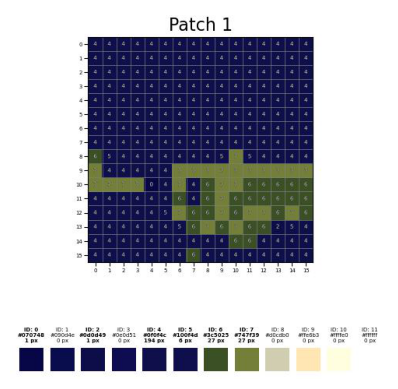

In [87]:
img = mpimg.imread('figures/patches/patch_001.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [60]:
# Step 1: Create a color-to-ID mapping from the resized image
color_to_id = {tuple(color): idx for idx, color in enumerate(unique_colors_surface)}

# Directory to save individual patches
output_dir = 'figures/patches'
os.makedirs(output_dir, exist_ok=True)

patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = image_array[
            i * patch_height: (i + 1) * patch_height,
            j * patch_width: (j + 1) * patch_width,
        ]

        # Count unique colors in the patch
        patch_unique_colors, patch_counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
        patch_hex_colors = ['#%02x%02x%02x' % tuple(color) for color in patch_unique_colors]
        patch_ids = [color_to_id.get(tuple(color), -1) for color in patch_unique_colors]  # Default ID is -1 for unmapped colors

        # Create a figure with gridspec for patch and swatches
        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)

        # Plot the patch
        ax_patch = fig.add_subplot(gs[0, 0])
        ax_patch.imshow(patch)
        ax_patch.set_title(f'Patch {patch_number}', fontsize=16)

        # Overlay IDs on cells
        for y in range(patch_height):
            for x in range(patch_width):
                color = tuple(patch[y, x])
                id_value = color_to_id.get(color, -1)  # Default ID is -1
                ax_patch.text(
                    x, y, str(id_value),
                    ha='center', va='center',
                    fontsize=5, color='white', alpha=0.7
                )

        # Create swatches with color counts and IDs
        gs_swatch = GridSpecFromSubplotSpec(1, len(patch_unique_colors), subplot_spec=gs[1, 0], wspace=0.3)
        for idx, (color, hex_color, count, id_value) in enumerate(zip(patch_unique_colors, patch_hex_colors, patch_counts, patch_ids)):
            ax_swatch = fig.add_subplot(gs_swatch[0, idx])
            ax_swatch.imshow([[color / 255]])  # Normalize RGB values
            ax_swatch.axis('off')
            ax_swatch.set_title(f"ID: {id_value}\n{hex_color}\n{count} px", fontsize=8, pad=5)

        # Save the figure in multiple formats
        patch_file_base = f'{output_dir}/patch_{patch_number:03d}'
        plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

        # Close the figure to save memory
        plt.close(fig)

        patch_number += 1

print(f"All patches with swatches saved to {output_dir}")


All patches with swatches saved to figures/patches


FileNotFoundError: [Errno 2] No such file or directory: 'figures/patches/test/test_patch_001.png'

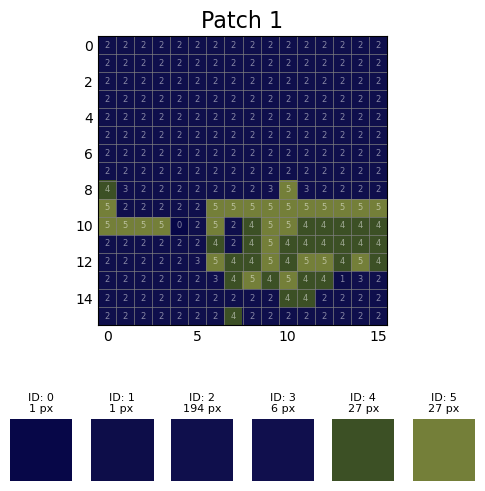

In [54]:
patch_number = 1
for i in range(n_patches_y):
    for j in range(n_patches_x):
        # Slice the patch
        patch = image_array[
            i * patch_height: (i + 1) * patch_height,
            j * patch_width: (j + 1) * patch_width,
        ]

        # Map unique colors to IDs
        unique_colors, counts = np.unique(patch.reshape(-1, 3), axis=0, return_counts=True)
        color_to_id = {tuple(color): idx for idx, color in enumerate(unique_colors)}

        # Create a figure with gridspec for patch and swatches
        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)

        # Plot the patch
        ax_patch = fig.add_subplot(gs[0, 0])
        ax_patch.imshow(patch)
        ax_patch.set_title(f'Patch {patch_number}', fontsize=16)

        # Add gridlines and labels
        ax_patch.set_xticks(np.arange(-0.5, patch_width, 1), minor=True)
        ax_patch.set_yticks(np.arange(-0.5, patch_height, 1), minor=True)
        ax_patch.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
        ax_patch.tick_params(axis='both', which='both', length=0)

        # Annotate each cell with its color ID
        for y in range(patch_height):
            for x in range(patch_width):
                cell_color = tuple(patch[y, x])
                color_id = color_to_id[cell_color]
                ax_patch.text(
                    x, y, str(color_id),
                    color="black" if np.mean(cell_color) > 128 else "white",  # Contrast text color
                    ha='center', va='center', fontsize=6, alpha=0.5
                )

        # Create swatches with color counts
        gs_swatch = GridSpecFromSubplotSpec(1, len(unique_colors), subplot_spec=gs[1, 0], wspace=0.3)
        for idx, (color, count) in enumerate(zip(unique_colors, counts)):
            ax_swatch = fig.add_subplot(gs_swatch[0, idx])
            ax_swatch.imshow([[color / 255]])  # Normalize RGB values
            ax_swatch.axis('off')
            ax_swatch.set_title(f"ID: {idx}\n{count} px", fontsize=8, pad=5)

        # Save the figure in multiple formats
        patch_file_base = f'{output_dir}/test/test_patch_{patch_number:03d}'
        # plt.savefig(f'{patch_file_base}.pdf', bbox_inches='tight')
        plt.savefig(f'{patch_file_base}.png', bbox_inches='tight')
        # plt.savefig(f'{patch_file_base}.jpg', bbox_inches='tight')

        # Close the figure to save memory
        plt.close(fig)

        patch_number += 1

print(f"All patches with swatches saved to {output_dir}")

img = mpimg.imread('figures/patches/test/test_patch_001.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Confirm that the patches were made correctly:

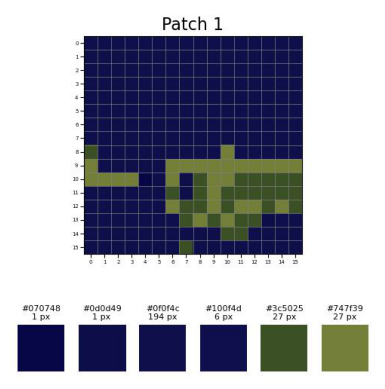

In [214]:
img = mpimg.imread('figures/patches/patch_001.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Success! Now where did that last piece go...